# Intro

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [22]:
data=10000
batch=100
set=100
layer=15
n_ini=1.0
n_fin=0.1
dn=(n_fin-n_ini)/layer
c_reg1=0.003
c_reg2=0.003
d=4

In [23]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

# Initial condition

<tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
array([7.48345428, 0.86924813, 6.9263004 , 6.74786045, 6.77102279,
       7.80504156, 4.17016715, 5.9480303 , 3.15508752, 4.61887207,
       6.38274463, 5.3896155 , 4.0359957 , 4.13323815, 4.9997631 ])>


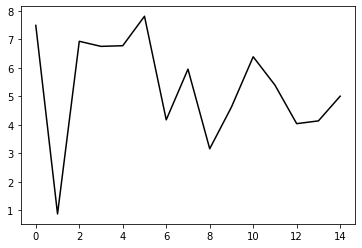

In [24]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(d, 3))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=-3
lamb=tf.Variable(np.float64(np.random.normal(0.2, 0)))
adsradius=tf.Variable(np.float64(np.random.normal(0.8, 0)))
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

# Data generation

In [7]:
x=[0, 0.000673563, 0.001347125, 0.00269425, 0.0053885, 0.010777, 0.021554]
y=[0, 0.006323923, 0.0115084, 0.021364605, 0.037943538, 0.067569123, 0.102948908]
f = np.poly1d(np.polyfit(x, y, 3))

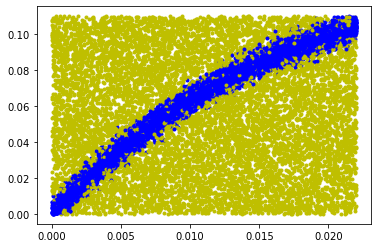

In [8]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 0.022)
        M=np.random.uniform(0.0, 0.11)
        noise=np.abs(np.random.normal(0, 0.004))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 0.022)
        M=np.random.uniform(0.0, 0.11)
        noise=np.abs(np.random.normal(0, 0.004))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

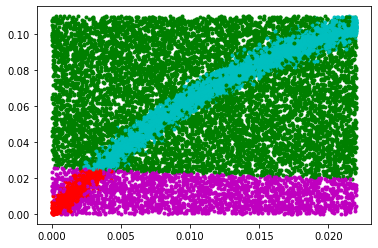

In [25]:
def onestep(phi, pi, hh, lam):
    phi1 = phi + dn*pi
    pi1 = phi*m2*dn + (1-dn*hh)*pi + dn*lam*(phi1**3)
    return phi1, pi1
def LP2(phi, pi, hh, lam, L):
    alpha = phi*L*np.sqrt(3)/(2*3.141592653589793)
    beta = pi*(L)**3*(3.141592653589793/np.sqrt(3))
    phi = alpha*(np.exp(-n_ini)) + beta*(np.exp(-3*n_ini)) - (1/2)*alpha**3*lam*n_ini*(np.exp(-3*n_ini))
    pi = - alpha*(np.exp(-n_ini)) - 3*beta*(np.exp(-3*n_ini)) + (3/2)*alpha**3*lam*n_ini*(np.exp(-3*n_ini)) - (1/2)*alpha**3*lam*(np.exp(-3*n_ini))
    for j in range (layer-1):
        phi, pi = onestep(phi, pi, hh[j], lam)
    return phi, pi
def NN_func_01(hh, lam, L, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(H, M, hh, lam, L)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, lamb, adsradius, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, lamb, adsradius, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, lamb, adsradius, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, lamb, adsradius, Negative[i])[1])
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [26]:
def Error_func(hh, lam, L, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(H0, M0, h, lam, L)
    H_1, M_1=LP2(H1, M1, h, lam, L)
    PPlist=t_func(M_0)**2
    NNlist=(1-t_func(M_1))**2
    sum_p=sum(PPlist)/batch
    sum_n=sum(NNlist)/batch
    inside=0
    for k in range (1, layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[0]-d)**2)
    return sum_n+sum_p+E_reg1+E_reg2

In [28]:
np.average([Error_func(h, lamb, adsradius, Positive[i], Negative[i]) for i in range (set)])

1.1879308883610697

# Optimize

0 1.2232718150685253
0.16076722982825503 0.7500000825720057
[7.43345553 0.91924691 6.87630131 6.69787135 6.7210427  7.75504432
 4.22015713 5.89803427 3.1051039  4.56887912 6.3327515  5.33962337
 3.98600335 4.08324585 4.95203937]


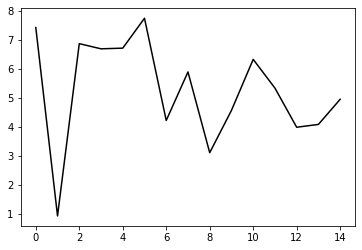

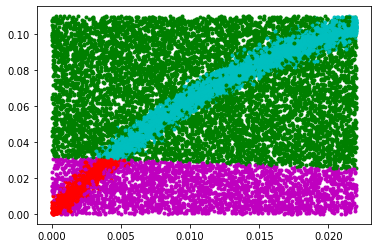

1000 1.00354789767021
1.742679613249025 1.806178315089015
[4.28081243 4.72741022 5.22901996 5.88102528 6.50155651 6.88639552
 6.88663677 6.53871716 5.98138417 6.34844091 7.29384664 7.01908163
 5.82956121 5.76929054 5.77098157]


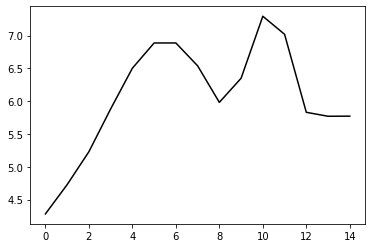

2000 0.9990882981379926
2.1834950077306887 2.0228203888814886
[4.02917248 6.22096165 6.22858707 6.24812462 6.28576058 6.348792
 6.44340302 6.57159435 6.72804612 6.89767363 7.04786695 7.05537664
 6.61798134 6.27068978 6.26974815]


3000 1.0000086911200547
2.3552420880487905 1.9693745477332263
[4.01002844 6.48140476 6.48301827 6.48721092 6.49569344 6.5112342
 6.53788223 6.58077385 6.64494445 6.73120825 6.82449553 6.86872861
 6.74536622 6.4493848  6.44838232]


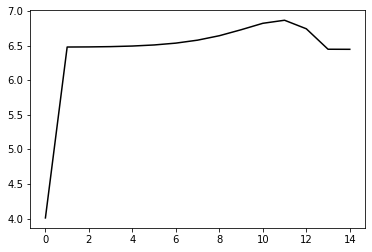

4000 1.00000179872223
2.5309071441881326 1.828840755808151
[4.01514205 6.82134668 6.81947729 6.81543529 6.80971642 6.80399445
 6.80102458 6.80417712 6.81711946 6.84282747 6.87957788 6.90986381
 6.87903988 6.71552462 6.71492148]


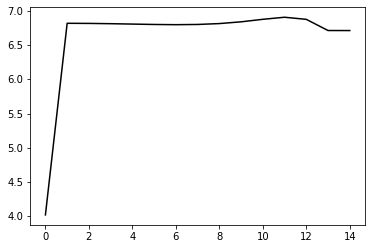

5000 1.009936695870448
2.62872815031148 1.7013418909821816
[4.01942228 7.0716422  7.06863658 7.06202523 7.05210287 7.04015866
 7.02793495 7.01728329 7.01039028 7.00975054 7.0167402  7.02541026
 7.00588863 6.90140973 6.9011386 ]


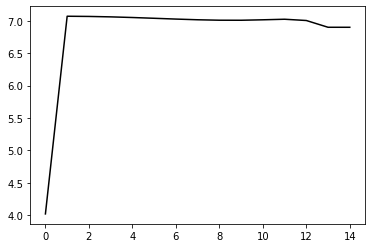

6000 1.0099356033234006
2.7196582065053727 1.6159580613954652
[4.01133583 7.2410752  7.23881675 7.23371378 7.22567052 7.21521442
 7.20312267 7.18999024 7.17635067 7.16289327 7.15037732 7.13795881
 7.11519667 7.05303354 7.05285127]


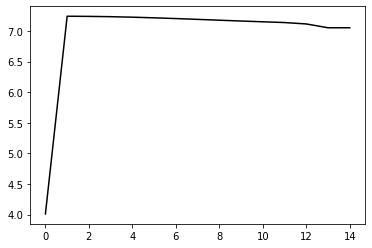

7000 1.0000378028081225
2.8803079809707874 1.5774289070564378
[4.02425037 7.35671504 7.35562891 7.35314334 7.34907521 7.34332568
 7.33561967 7.32535499 7.31181944 7.29455592 7.27353779 7.2486674
 7.21794117 7.17572386 7.17558317]


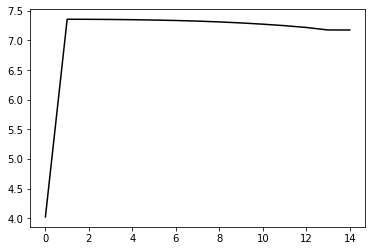

8000 0.9929253249809372
3.137496665569498 1.0068994720519655
[4.17682665 7.60926509 7.59140709 7.56019211 7.52166505 7.48235772
 7.4465929  7.4153648  7.38725775 7.35984875 7.33071405 7.29805411
 7.26063684 7.21881673 7.22902796]


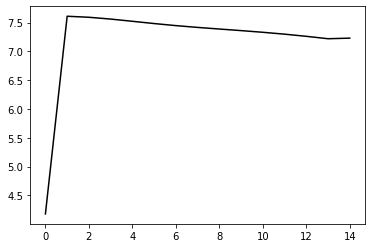

9000 0.9761756017612873
3.5207358778039195 0.4381655910009252
[4.54787014 8.91754035 8.86811141 8.79222366 8.70329153 8.61037371
 8.5206073  8.44000328 8.37217372 8.31656185 8.26889834 8.22403755
 8.17826689 8.13119301 8.05997904]


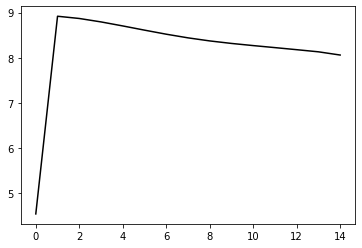

10000 1.000179313880237
3.529833864138589 0.09273103414523716
[ 4.20196435 10.05878013 10.01823134  9.93671421  9.82480622  9.69822594
  9.57250768  9.45924221  9.36476884  9.28991102  9.23019552  9.17845899
  9.12875666  9.07960742  9.07950667]


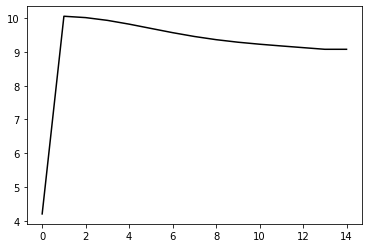

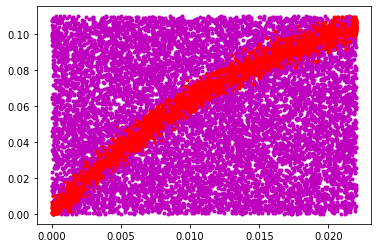

11000 1.0000052839285316
3.4401658048921444 -0.0809466976134226
[4.00022398 9.57552024 9.57388592 9.56644633 9.55457817 9.5361158
 9.51203279 9.47676193 9.42856599 9.35900125 9.26286801 9.14614445
 9.03290052 8.95318994 8.95214842]


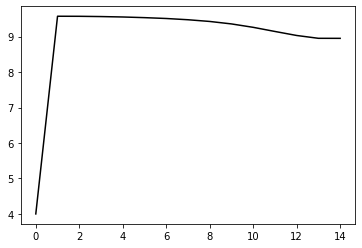

12000 0.9663065393596484
3.086566986667087 -0.30491699657678073
[ 4.36386776 10.77407416 10.74761326 10.70807683 10.6675722  10.63517146
 10.61376225 10.60051679 10.59228905 10.55585404 10.49247469 10.39884502
 10.27792951 10.1586488  10.04442962]


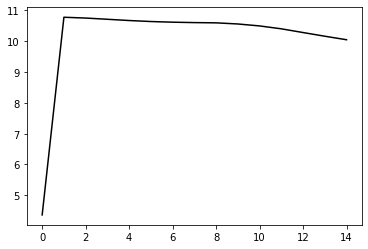

13000 1.0203558076677004
2.59806665735386 -0.231637877163482
[ 4.16119976 11.19378036 11.17361721 11.13815436 11.0932785  11.04530309
 11.00062916 10.96377532 10.93295385 10.89500139 10.83401731 10.74197373
 10.62113809 10.50014596 10.45465207]


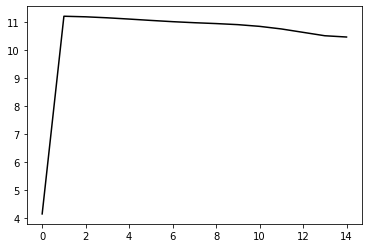

14000 0.8968121305068658
1.8619391276107193 -0.1886191612198468
[ 4.06501009 11.25737276 11.23622184 11.2012326  11.15553069 11.10279509
 11.04808326 10.996673   10.95079498 10.9044121  10.8425055  10.75164044
 10.6310685  10.50885965 10.53615824]


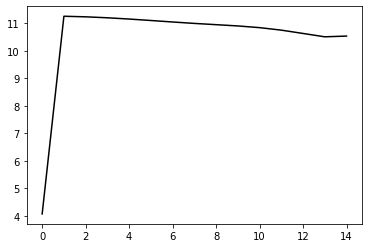

15000 1.0000085635901996
1.7214686498030871 -0.008135370222673955
[ 4.00000015 11.00691316 10.99656621 11.00522208 10.99201393 10.97626282
 10.98985615 10.8960274  10.92994806 10.87667974 10.81137739 10.71841186
 10.59840175 10.47160977 10.42126692]


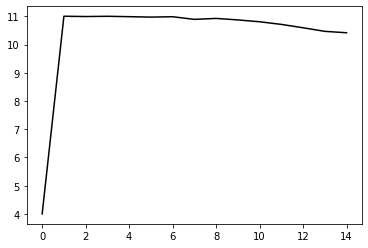

16000 0.9473290125050675
1.6342995256614692 -0.3048846835497361
[ 4.17114635 11.13670225 11.14231569 11.12935512 11.11536011 11.09979949
 11.08638817 11.06824895 11.05528928 11.05155618 11.06752795 11.09856847
 11.14860428 11.19406452 11.12802006]


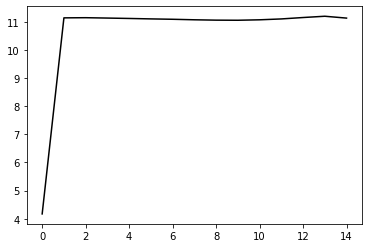

17000 0.9999997883562823
1.3263668865047227 0.03151632497019065
[ 4.00004525 10.91603851 10.91548266 10.91411254 10.91158291 10.90744256
 10.90122081 10.89265717 10.88230748 10.87274268 10.87012809 10.88405395
 10.92085928 10.96678709 10.96724155]


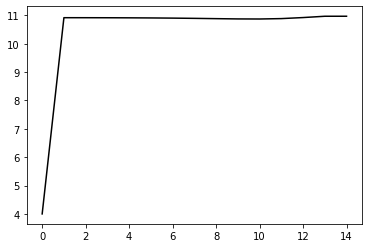

18000 1.000000189363276
1.2067044377469738 -0.008813772838801234
[ 4.00000016 10.69693204 10.69738305 10.69848528 10.70053517 10.70394374
 10.70923934 10.7170003  10.72762402 10.74080724 10.75486985 10.7673604
 10.77988231 10.79918323 10.82137469]


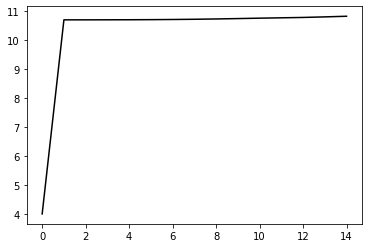

19000 1.00000481061541
1.2067044633805928 -0.030978110924627225
[ 3.99999189 10.72078188 10.6982003  10.72210145 10.6968027  10.72315543
 10.6962697  10.72308613 10.6976588  10.71993215 10.70258035 10.71506489
 10.70707045 10.71259104 10.70898341]


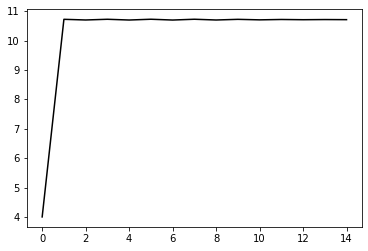

20000 0.9887921325722487
0.7039399719731281 -0.10525883698042987
[ 4.04894859 10.79771409 10.78237028 10.75866028 10.73037958 10.70322114
 10.68353499 10.67704853 10.69053598 10.71573257 10.73697275 10.76938959
 10.7715099  10.79946865 10.92183536]


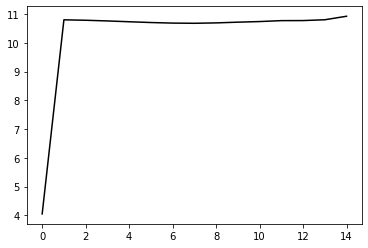

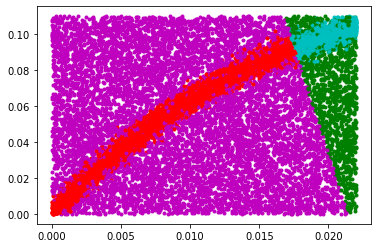

21000 0.8639474084837632
0.5895655470621551 0.2036126025057836
[ 4.12534261 11.03270231 11.02401664 11.01508554 11.00642712 10.99771533
 10.98904163 10.98100691 10.97495033 10.9736673  10.98129295 10.99920011
 11.01865463 11.04132454 11.05775424]


22000 1.0000040734535445
0.024915303150132805 0.027574175137678687
[ 3.97127326 10.9386557  10.93219664 10.91851719 10.89931565 10.87841505
 10.85952615 10.84451846 10.83409626 10.82966927 10.83420622 10.84943997
 10.86868974 10.89094395 10.89095381]


23000 0.9700735058883538
-0.19660901655267932 -0.16370354724834585
[ 3.90829344 10.76548034 10.76032736 10.75471174 10.75162444 10.74672011
 10.74865486 10.7494402  10.75639594 10.76805255 10.77476512 10.77415066
 10.77123127 10.77053482 10.85516824]


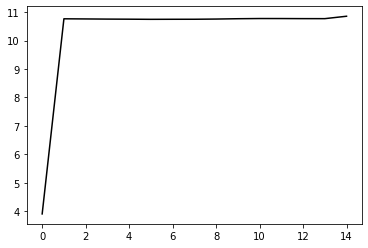

24000 0.9883946908478946
-0.9070967730285755 0.17809219108497057
[ 3.99505279 10.84329213 10.83259057 10.81719516 10.80041501 10.78475857
 10.77276889 10.76644034 10.76658459 10.7722899  10.7781183  10.77849671
 10.77552615 10.77421916 10.77920828]


25000 0.9514282641623827
-1.6303259290363514 0.2766418503714891
[ 4.13697099 11.13940353 11.12444452 11.09862826 11.06794383 11.0374953
 11.01158132 10.99324901 10.9839643  10.9829454  10.98581393 10.98607884
 10.98294845 10.98098881 10.88923273]


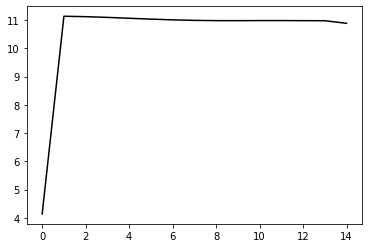

26000 1.000002669116334
-2.2621151963110906 -0.01222221661501029
[ 3.99188154 10.9051407  10.89546143 10.87898659 10.86000014 10.83992652
 10.81818065 10.7946567  10.77146078 10.75304267 10.74314685 10.73982655
 10.73714146 10.73460784 10.73460606]


27000 1.0000747804157002
-2.2621151841391813 -0.012614913677673888
[ 4.00011218 10.91330396 10.77270993 10.8792563  10.81043608 10.84633705
 10.82683517 10.83167637 10.82332798 10.82176396 10.80777274 10.79825215
 10.7790311  10.75907877 10.75833922]


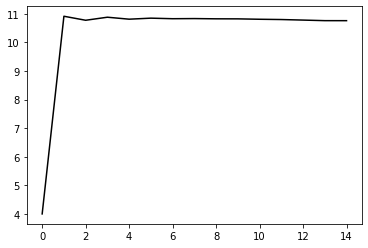

28000 1.0000031147847253
-2.565354654570157 -0.004287774303263837
[ 3.98179293 10.78839376 10.77749083 10.75946323 10.74062509 10.72676359
 10.71992558 10.72835746 10.74445938 10.77116198 10.81086195 10.83139998
 10.86088973 10.86087708 10.8608769 ]


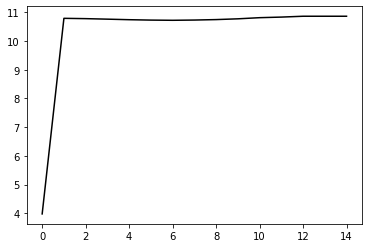

29000 1.0000353955205656
-2.5653546544778707 -0.004359143815501979
[ 4.00160051 10.76746647 10.74381653 10.79507714 10.70186609 10.8050659
 10.73160748 10.78412986 10.74425143 10.80051217 10.75498867 10.79358569
 10.80520907 10.8261888  10.82702221]


30000 0.9605943452776446
-2.5831054533729207 -0.3989498733083181
[ 4.0855515  10.90496108 10.90311519 10.89552326 10.89519277 10.89602396
 10.9033605  10.90691534 10.92529236 10.91832515 10.95246956 10.95358473
 11.00810698 11.09751262 11.00061196]


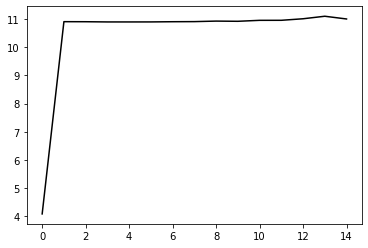

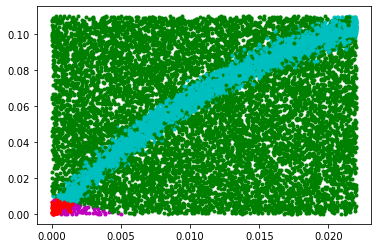

31000 0.9999975709759235
-3.0932674310939783 0.045632485074753135
[ 4.00032844 10.67828924 10.67761147 10.67600931 10.67324981 10.66926441
 10.66444083 10.66002773 10.65834974 10.66222267 10.67362246 10.69210965
 10.73610438 10.81579811 10.81530215]


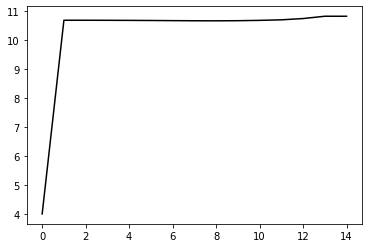

32000 0.9008377211374042
-3.4519378994562198 -0.19302197890816586
[ 4.15949576 11.01435159 10.99893649 10.97896016 10.96063334 10.946244
 10.93541618 10.92719678 10.92138577 10.91909092 10.92303212 10.93831652
 10.9739345  11.0369539  11.06272898]


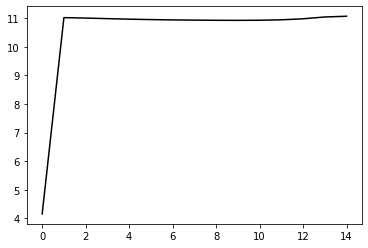

33000 1.0000008062601107
-3.878354028616518 -0.0020386622674243415
[ 3.99999917 10.93608353 10.93424731 10.92985967 10.92214731 10.91055532
 10.89528863 10.87802696 10.86221673 10.85201734 10.85080954 10.86247219
 10.89435025 10.951729   11.00430388]


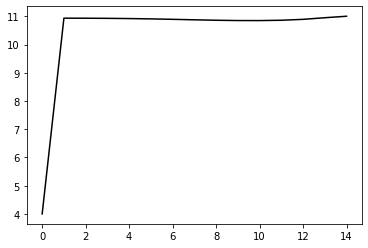

34000 1.0000201143166125
-3.8783540286098277 -0.002390771850791661
[ 3.99999903 10.93770633 10.90363496 10.85689564 10.9398107  10.88383231
 10.91637964 10.89703202 10.90846932 10.90103699 10.90597083 10.90252575
 10.90521666 10.90349764 10.90458645]


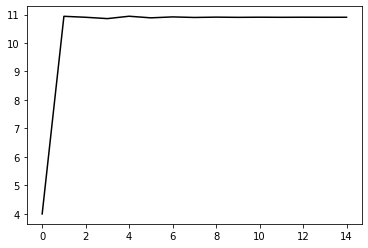

35000 1.0000599752136137
-3.9196078410885558 0.0096808211259818
[ 4.00000019 10.63656049 10.74059993 10.6214713  10.69910722 10.66925969
 10.67543875 10.67270602 10.67055624 10.66773027 10.66494688 10.66401971
 10.66769948 10.66270434 10.66266947]


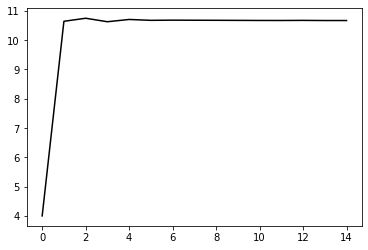

36000 0.827367041356325
-3.992124819421614 0.27397195137886426
[ 4.12033777 10.80952341 10.80139998 10.79781495 10.80011693 10.79134116
 10.8091484  10.77616098 10.82637099 10.7603896  10.83990923 10.7545924
 10.85066945 10.76792027 10.82779056]


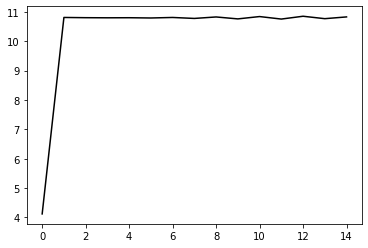

37000 1.0000002611686438
-4.345393867902581 0.011688639987840446
[ 4.00000021 10.72691286 10.72601497 10.72385576 10.72003303 10.71423774
 10.70652343 10.69768702 10.68949392 10.68428091 10.68317594 10.67262436
 10.70625354 10.65731706 10.68794251]


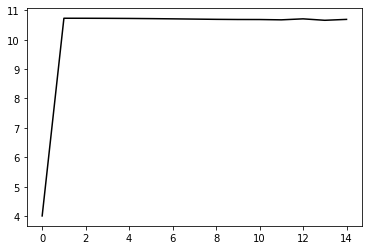

38000 1.0000250865999176
-4.3453938562706425 0.015847999499094163
[ 3.99973828 10.68863798 10.73565544 10.66997338 10.74671872 10.68653433
 10.71393032 10.71011336 10.70656647 10.71094528 10.70702892 10.71063766
 10.70735456 10.71000911 10.70735083]


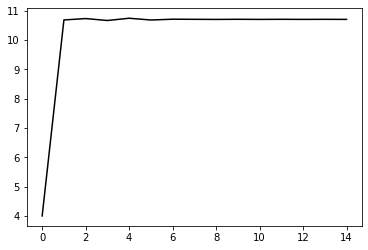

39000 0.9396970323460894
-4.989854475081508 0.19846971824528242
[ 4.06233799 10.97071832 10.95666735 10.93541002 10.91358611 10.8962386
 10.88497791 10.87945481 10.8737918  10.87491105 10.86939557 10.87481037
 10.86986767 10.87962046 10.92295752]


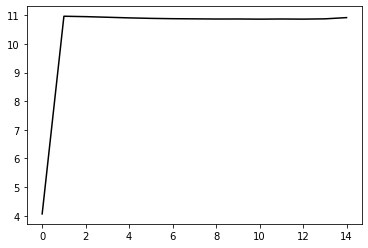

40000 1.0000101519205895
-5.6098694872216885 0.00014596417090100814
[ 3.9595082  11.10823018 11.09219298 11.06605444 11.03368016 11.00052655
 10.97201377 10.95144766 10.93882956 10.93257337 10.92761598 10.92913418
 10.92519226 10.9333458  10.98888   ]


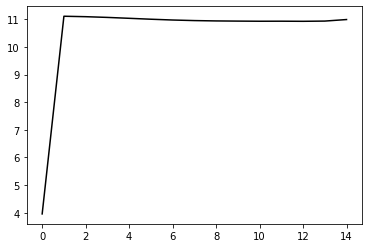

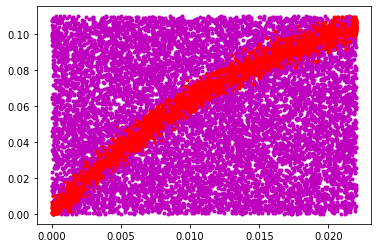

41000 1.0000520641868942
-5.615100831850511 -0.010105951295719126
[ 3.95000598 11.00781251 11.01744387 10.9948337  11.05160668 10.94271979
 11.06916067 10.94154671 11.05887003 10.95044506 10.98825343 10.96604026
 10.94988292 10.93436224 10.93385692]


42000 1.0000718319969233
-6.054618395579071 0.015815134637197158
[ 3.84551712 10.76011934 10.75616964 10.74926699 10.74329373 10.7422033
 10.74699742 10.75151867 10.76351553 10.76282561 10.77226071 10.76828327
 10.77500329 10.77450108 10.77450064]


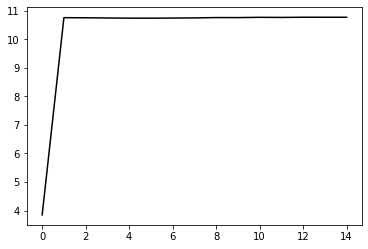

43000 1.0000672041760867
-6.054618352938082 0.016363295759019156
[ 3.9999079  10.67731417 10.81428094 10.71587032 10.77532474 10.74525014
 10.7591487  10.75368338 10.75808692 10.75433305 10.76178566 10.761381
 10.76617147 10.76962063 10.7700275 ]


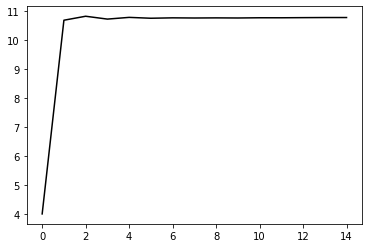

44000 1.0000096807801995
-6.426378304804741 0.0063480012806299115
[ 3.94763135 10.7414628  10.73108195 10.7160832  10.70280386 10.69389058
 10.6887659  10.68425201 10.68852194 10.6740023  10.70087861 10.66238966
 10.72451871 10.67749227 10.67720494]


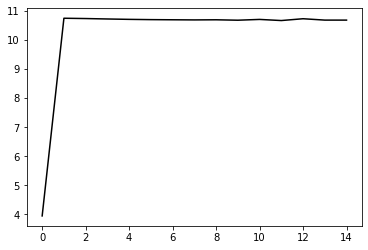

45000 1.0000462986772711
-6.426378304387997 0.006433936550660236
[ 3.95189836 10.703769   10.70905191 10.6963189  10.73322465 10.64863889
 10.77511165 10.63362128 10.76834357 10.67105147 10.70564043 10.69723879
 10.69438686 10.69105927 10.6908813 ]


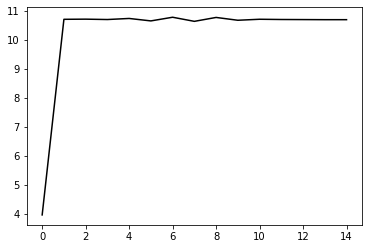

46000 0.9443383594710214
-6.482901503083881 0.19937242641266023
[ 4.09386024 10.8426159  10.8318953  10.82273713 10.81410368 10.81404194
 10.8025697  10.81600213 10.79208292 10.82241508 10.78555112 10.82695782
 10.78868059 10.83290487 10.85191943]


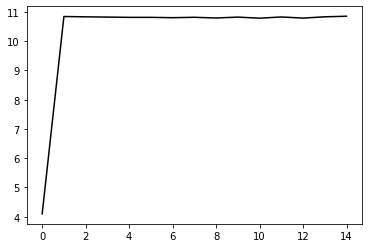

47000 0.9999999386931295
-6.854731013382134 -0.02845990626754979
[ 4.00000974 10.63458304 10.63420984 10.63330281 10.63164714 10.62898423
 10.62506688 10.61980273 10.6135311  10.60736998 10.60329209 10.6029535
 10.59769549 10.61997148 10.62029547]


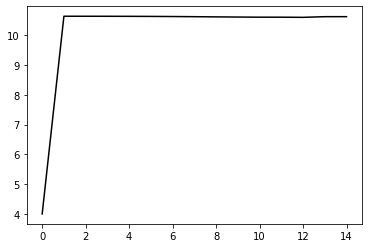

48000 0.9346728219508458
-7.188509695410152 -0.214672315177287
[ 4.08903366 10.89179284 10.87546879 10.8524609  10.83085477 10.81408123
 10.80696227 10.80300904 10.80911002 10.81277999 10.8293154  10.85275177
 10.8689841  10.87091327 10.86494342]


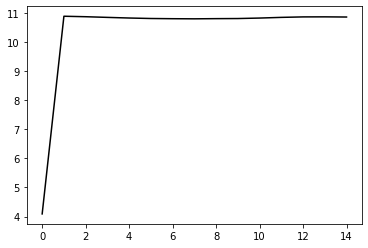

49000 0.9812558776145551
-7.352678128896665 -0.38912983888968866
[ 4.22070925 10.89247318 10.88034598 10.87941237 10.88972133 10.90839216
 10.93347816 10.95323096 10.95997756 10.96039129 10.96105437 10.96641667
 10.97849532 10.99035254 10.99991753]


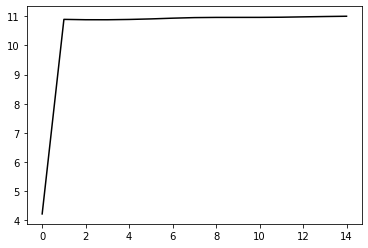

50000 1.0000000172246455
-7.836762959599802 -0.013925601178925393
[ 4.00000027 10.63985788 10.63988129 10.6399723  10.64025723 10.64101755
 10.64275811 10.646124   10.65135186 10.65726439 10.66192101 10.6668364
 10.6764595  10.68803007 10.68762036]


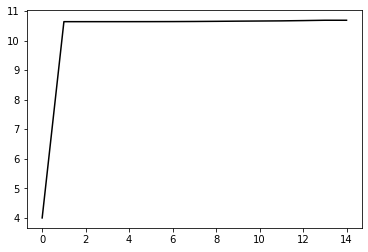

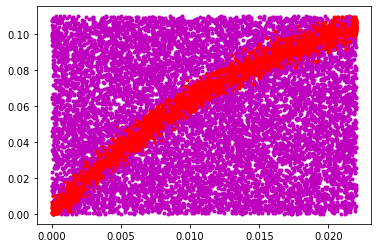

51000 1.0000345870275795
-7.8367629318770815 -0.019898565247855368
[ 3.99990338 10.62420693 10.6799253  10.58749175 10.67587501 10.63916729
 10.64451527 10.64881796 10.64374259 10.64814478 10.64464089 10.64784748
 10.64530482 10.6475767  10.64574981]


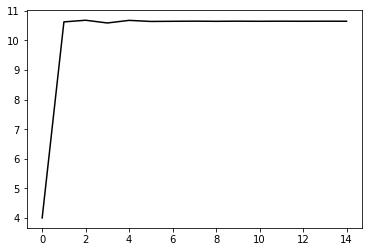

52000 1.0000023188362506
-8.020477156064851 -0.032419600428869016
[ 3.98543252 10.78345444 10.78020198 10.77404883 10.76746279 10.76395625
 10.76580952 10.7735559  10.79260903 10.81244599 10.87560778 10.97022899
 11.03123469 11.17838228 11.17852967]


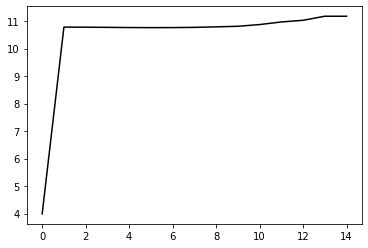

53000 1.0000020628747215
-8.223873435320607 0.011265748442464698
[ 3.99534638 10.87365722 10.8741516  10.87637381 10.88309652 10.89769416
 10.92047162 10.94638924 10.96922732 10.99049804 11.01979823 11.06852302
 11.14703593 11.2511005  11.25123696]


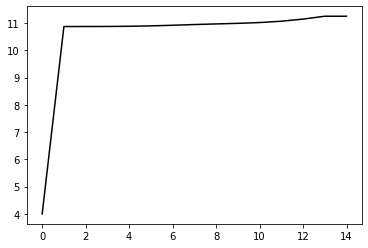

54000 1.0000001285985929
-8.223873422571153 0.012608632020680534
[ 3.99868547 10.92227949 10.91852486 10.92117336 10.92511168 10.92180126
 10.92787413 10.92802451 10.93408615 10.9369508  10.94555774 10.9526423
 10.96708059 10.98425604 10.98414847]


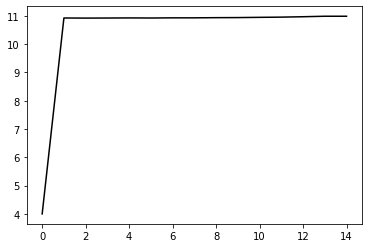

55000 0.9999982597018668
-8.373763673911357 0.04250576907308473
[ 4.00024034 10.70899349 10.70946126 10.7106198  10.71284878 10.71669744
 10.72302424 10.73299163 10.74794972 10.76862485 10.79295671 10.81321307
 10.83172227 10.83004971 10.84400186]


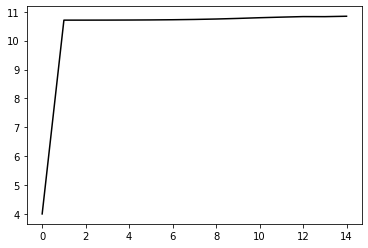

56000 1.000000413136477
-8.780724146797446 0.022058807765997824
[ 4.00563797 10.56927199 10.56899997 10.568716   10.56932587 10.57250696
 10.58005432 10.59232166 10.60762077 10.62443837 10.64372987 10.66632127
 10.68773485 10.69617856 10.69619404]


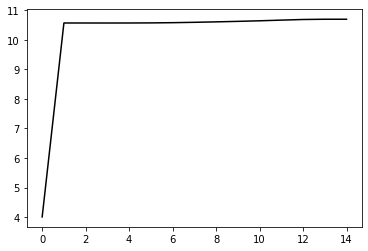

57000 0.9999999914029959
-8.78072377264817 0.03075152371686201
[ 3.99993395 10.58720455 10.58749327 10.58744814 10.58805677 10.5885851
 10.58844207 10.59192681 10.58688631 10.59900618 10.58224341 10.60863072
 10.5908148  10.60105908 10.59722174]


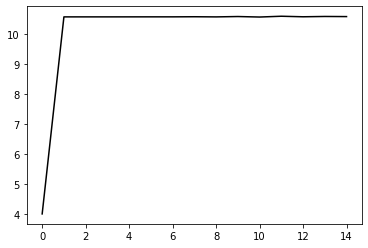

58000 1.000004100935307
-9.425615356964183 0.04240302094363925
[ 3.96704025 10.77701172 10.76472257 10.74248183 10.71699717 10.69511326
 10.68073388 10.67443972 10.67208574 10.6761254  10.67937191 10.69485103
 10.71967527 10.75271201 10.75271127]


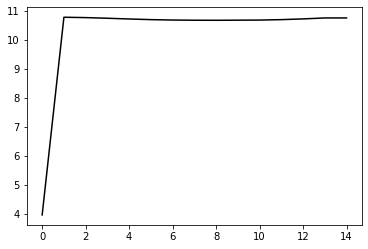

59000 1.000001069249946
-9.625335376130181 0.015891699358886156
[ 4.00303236 10.85253988 10.84774117 10.83770483 10.82383857 10.80877328
 10.79435846 10.78092815 10.76878586 10.75986497 10.75780332 10.76619907
 10.78706635 10.81718379 10.81720601]


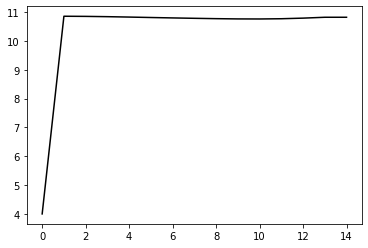

60000 1.000021771933915
-9.62533531760662 0.017669502522170102
[ 3.9999769  10.81203242 10.80830786 10.81779867 10.7932858  10.8419892
 10.76265548 10.86616416 10.75442326 10.85833943 10.7579737  10.83734606
 10.79758535 10.80125105 10.80026491]


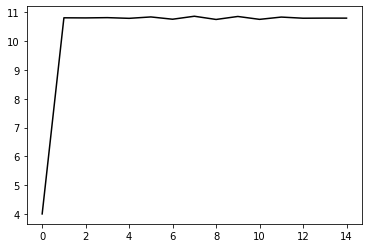

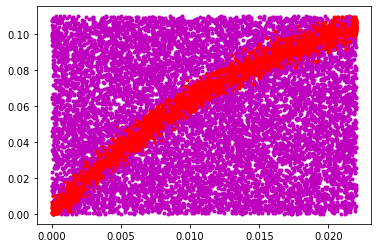

61000 1.0000075285225258
-9.649254041475302 -0.022443917875773756
[ 3.95003687 10.66704974 10.67168338 10.66751916 10.67059922 10.66835951
 10.66914043 10.66778348 10.66784879 10.66617796 10.66608593 10.6633128
 10.6619296  10.65871312 10.65686882]


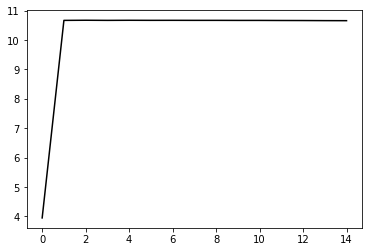

62000 0.9999999918477392
-9.666922056468076 2.8236843269576845e-06
[ 4.00000012 10.67433376 10.67435463 10.67428051 10.67423658 10.67409694
 10.67398342 10.67378454 10.67361678 10.67338901 10.67320207 10.6729964
 10.67286006 10.67269569 10.67266884]


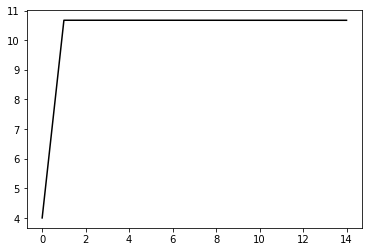

63000 1.0000207088381317
-9.666922056468076 6.0307395106009356e-05
[ 3.91689955 10.67413746 10.67419411 10.67413745 10.67419432 10.6741374
 10.6741947  10.67413676 10.67419477 10.67413366 10.67419267 10.67412592
 10.67418609 10.67411547 10.67417437]


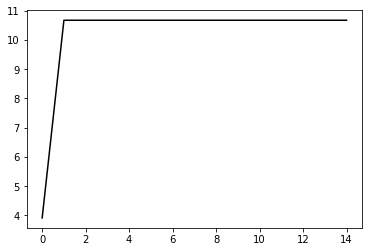

64000 0.9247550662309008
-10.19448550104435 0.21301417652543694
[ 4.09150269 10.87255323 10.85820649 10.8376901  10.81769869 10.80215146
 10.79188789 10.7856829  10.78196662 10.77963943 10.77823197 10.7772861
 10.77691238 10.77683964 10.77450415]


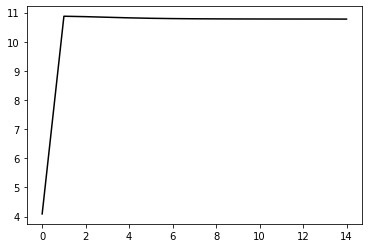

65000 0.9991888482558721
-10.757916654621374 0.07222222731023062
[ 3.92677896 10.83046555 10.82150969 10.80839491 10.79340208 10.77693636
 10.75922061 10.74160826 10.72666499 10.71650851 10.71099382 10.70833022
 10.70710962 10.70662316 10.76694591]


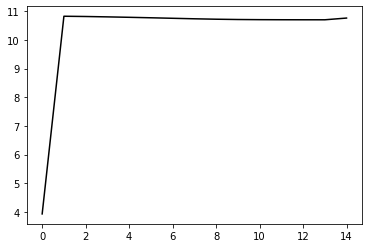

66000 1.0000011129606527
-11.041646091923141 -0.009506510632386299
[ 3.99998452 10.85688734 10.85476942 10.84969528 10.84071836 10.82704587
 10.80856702 10.78656508 10.76406873 10.74496681 10.73204802 10.72535868
 10.72258738 10.72150949 10.74944417]


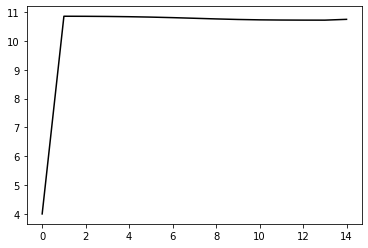

67000 1.0000234567478081
-11.04164608732176 -0.011831083414976714
[ 4.00000991 10.84770344 10.81428775 10.76299628 10.85297141 10.79050735
 10.82682473 10.80574987 10.81766696 10.80955784 10.81417641 10.80997896
 10.81229913 10.80977673 10.81073722]


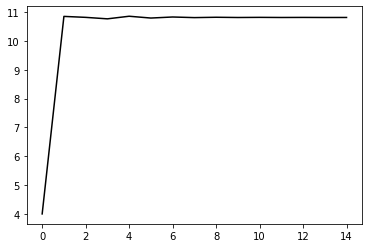

68000 1.000046569640681
-11.636521260026658 -0.032733963296394
[ 3.87767963 10.65797512 10.64791425 10.63179872 10.61520738 10.60353442
 10.60131541 10.61260819 10.63174963 10.66250907 10.70195996 10.74045486
 10.75407089 10.76952496 10.76877926]


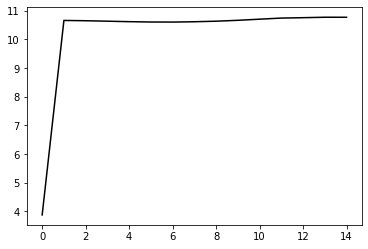

69000 1.000072852265864
-11.636506807758831 -0.05294543076188887
[ 4.0018859  10.56241531 10.70972065 10.59533081 10.66734641 10.63080486
 10.65146856 10.64335674 10.66625451 10.64919631 10.68475948 10.69054111
 10.71664055 10.74537245 10.78017627]


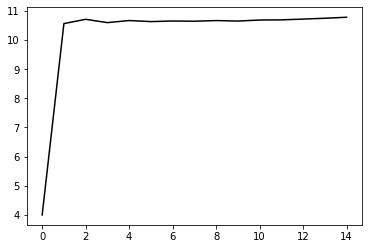

70000 1.0000005556235967
-12.29047205886381 -0.03770326128899015
[ 3.99099937 10.72494243 10.7203182  10.71090278 10.69903926 10.68950064
 10.68744196 10.69646497 10.71863573 10.75208131 10.78207459 10.80449679
 10.82733394 10.85479483 10.85480528]


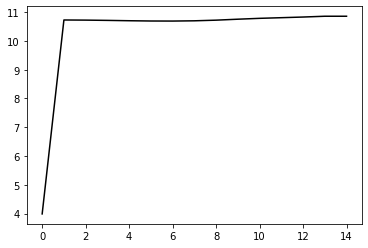

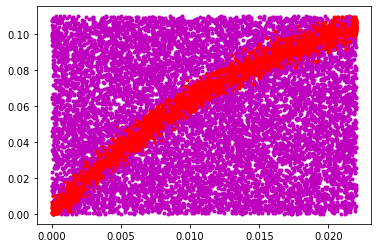

71000 1.0000002427202512
-12.421246561601947 -0.018729898549763563
[ 4.00046028 10.85107136 10.8513822  10.85225965 10.85423029 10.85812901
 10.86479275 10.87411681 10.88461859 10.89628466 10.91244112 10.93635291
 10.96695161 10.99652229 10.99656872]


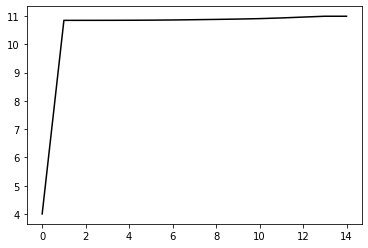

72000 0.965512865077168
-12.399757068862645 -0.3891646104125992
[ 4.12614043 11.03383268 11.02796751 11.01960125 11.01750243 11.02401624
 11.03543016 11.04717999 11.05751556 11.07238795 11.09055945 11.12991948
 11.15403497 11.16178784 11.14276658]


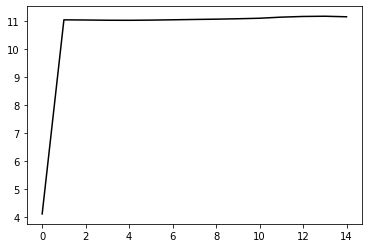

73000 1.000000058472263
-12.83460662955206 0.023861590753970208
[ 4.00000562 10.74594119 10.74578409 10.74542185 10.74483646 10.74411371
 10.74359753 10.74415581 10.74750212 10.75626132 10.77326422 10.79997889
 10.82822036 10.84242031 10.84243872]


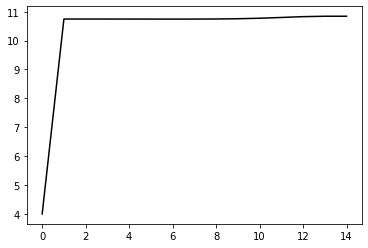

74000 0.9999997457734003
-12.979668448232344 0.0402386159697842
[ 3.99273672 10.55200564 10.55224077 10.55293201 10.55445647 10.55752312
 10.56279771 10.57048712 10.58053076 10.59378179 10.61654062 10.65121397
 10.67885849 10.68829332 10.68830074]


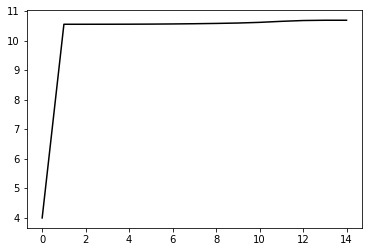

75000 1.0000000309941242
-13.076921114371086 0.024783468843350878
[ 4.00000488 10.61346125 10.61349472 10.61358673 10.6137917  10.61422938
 10.61515107 10.61706616 10.6209399  10.62840603 10.6417299  10.66294445
 10.69090354 10.71416071 10.71424944]


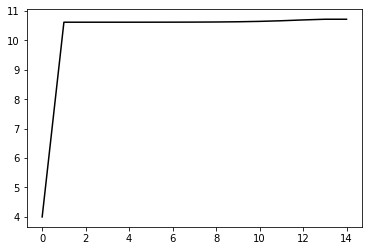

76000 1.0000004669981526
-13.223744806088437 0.03420206166227889
[ 4.00073616 10.62954544 10.62951919 10.62976789 10.63122708 10.63585182
 10.64654934 10.66593517 10.69357974 10.72532426 10.75489197 10.77838161
 10.79004175 10.79982383 10.79983848]


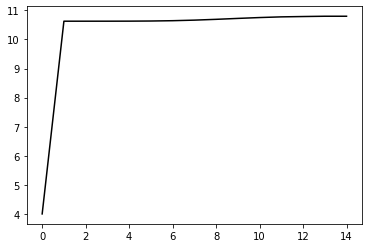

77000 0.9687363761347023
-13.47294009471607 0.2886997166418329
[ 4.09754074 11.1497846  11.14569274 11.14349532 11.15229259 11.17890829
 11.22129513 11.26709486 11.30203475 11.32369528 11.34222738 11.36547453
 11.39462754 11.42026471 11.40522722]


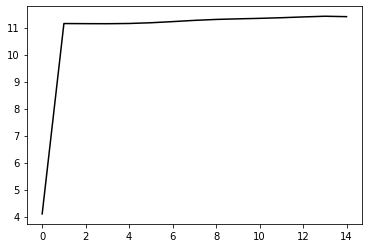

78000 1.0001877716838952
-13.762832899992322 -0.016426039908513095
[ 4.00000144 10.75347975 10.93916729 10.73673128 10.88321469 10.82613297
 10.84815293 10.85702522 10.87397066 10.89799564 10.93017388 10.96848679
 11.00709915 11.03915595 10.99674182]


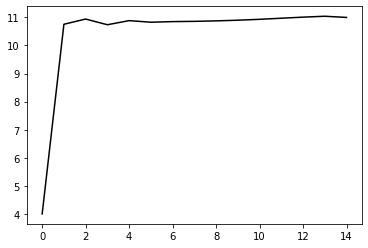

79000 0.9285582641731197
-13.91968419978267 -0.3070375194045275
[ 4.09295431 10.91388128 10.90424019 10.89519191 10.8956478  10.90995379
 10.93611243 10.9689342  11.00494971 11.03510923 11.06116946 11.07406558
 11.0869538  11.09072465 11.10307282]


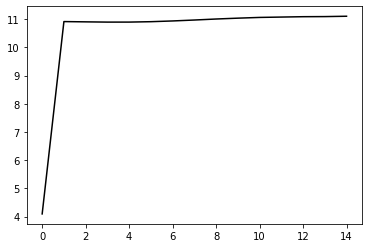

80000 1.0000009462291084
-14.325020876221716 -0.006692678555733161
[ 4.00120343 10.65538628 10.65187119 10.64382453 10.63113713 10.61589271
 10.60315951 10.59885506 10.60507233 10.62085013 10.64468079 10.6726451
 10.69642509 10.70897099 10.70904917]


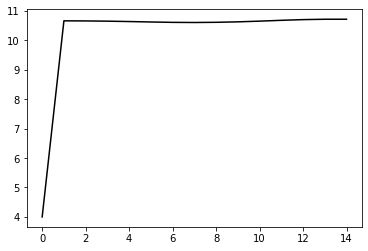

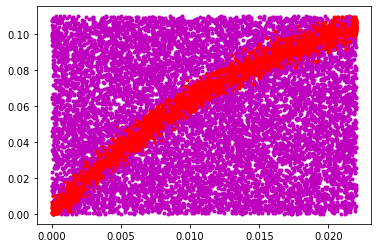

81000 0.999999989244266
-14.325020875711292 -0.006934835189788335
[ 3.99999822 10.63462105 10.63466666 10.63465355 10.63474416 10.63476888
 10.634913   10.63497078 10.63513943 10.63520953 10.63531701 10.63536142
 10.63532288 10.63536046 10.63521567]


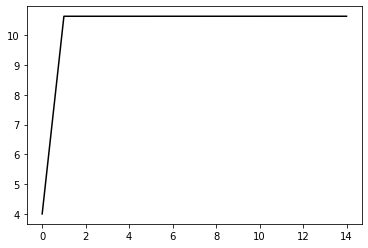

82000 1.0000151930955876
-14.60939874437694 0.024310844729512483
[ 3.93620176 10.53620329 10.52279443 10.50620083 10.49387158 10.49024633
 10.49644746 10.512825   10.54882022 10.54871949 10.61548187 10.56207521
 10.64976052 10.55279738 10.59271516]


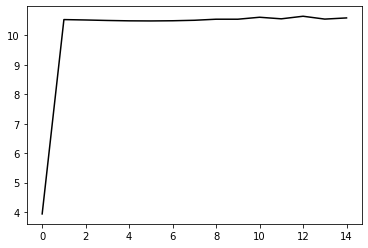

83000 1.0000054921736738
-14.609398574512499 0.02545846199833125
[ 3.96250895 10.51869079 10.51951256 10.51847601 10.52391868 10.51345003
 10.53949815 10.51101104 10.53942486 10.53567117 10.54658486 10.55799133
 10.57105022 10.57795505 10.57801711]


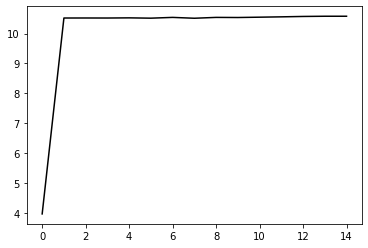

84000 0.9131916928531574
-15.056319813471015 -0.20628186756633815
[ 4.09265618 10.69011659 10.67599293 10.65742149 10.64040671 10.62783548
 10.61920207 10.62124538 10.60651072 10.63624543 10.61090659 10.66213061
 10.66425969 10.66755334 10.65318453]


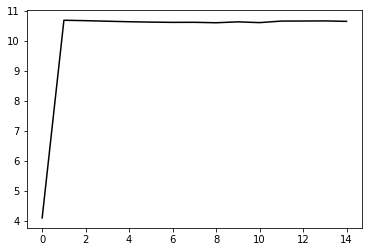

85000 0.9895058939932765
-15.632043778619574 -0.1671233083194687
[ 4.07631048 11.13937001 11.11906996 11.08675302 11.04882005 11.01252617
 10.98375593 10.96477546 10.95453425 10.95844173 10.95115004 10.98501881
 10.99193679 10.99472538 11.04516345]


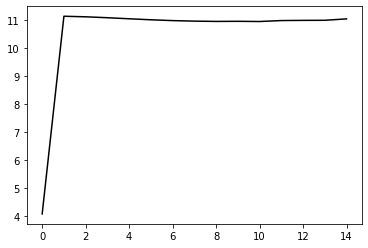

86000 1.0002096358776886
-15.815850293064173 -0.02535361127106261
[ 4.00001193 10.82891559 11.01178878 10.82940935 11.02120827 10.87901737
 10.92101431 10.90609186 10.89628359 10.88308421 10.86978892 10.86223153
 10.8656595  10.87283171 10.83025838]


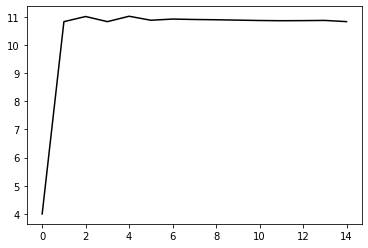

87000 0.9999993429034407
-16.195540553880345 -0.034281492141607826
[ 3.99681812 11.03763763 11.03344247 11.02474943 11.01328387 11.00243095
 10.99495958 10.99122707 10.99007674 10.99115161 10.98891305 10.98571761
 10.97819865 10.96875152 10.96873806]


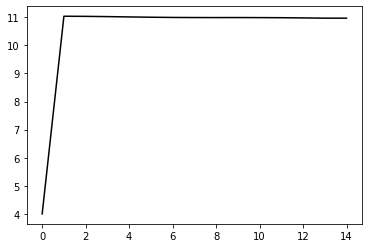

88000 0.9698905965070206
-16.610920522110586 0.1477267224297344
[ 4.01088417 11.01785483 11.00336998 10.98446611 10.96614796 10.95112436
 10.93972144 10.93081278 10.92312306 10.91596196 10.9093688  10.9033806
 10.89647676 10.88779709 10.99206282]


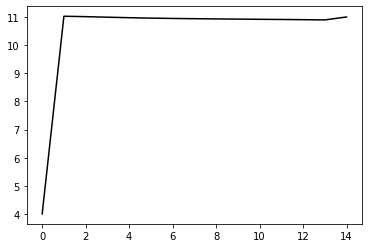

89000 1.0000006163628368
-17.031561134502606 0.02453081087360809
[ 4.00000563 10.97580543 10.9738991  10.96934771 10.9613596  10.9493726
 10.93357617 10.91551043 10.89803427 10.88375974 10.87310416 10.86477239
 10.85689505 10.84816511 10.84769192]


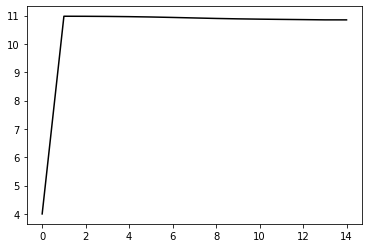

90000 0.9999248407245301
-17.392064531094476 -0.06436636978505855
[ 3.92316572 10.66854366 10.66652594 10.66210353 10.65551315 10.6484193
 10.643112   10.64089028 10.64234255 10.64947441 10.65154008 10.64657539
 10.63394738 10.61739835 10.61672932]


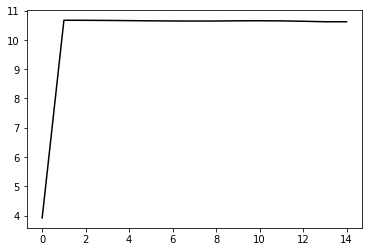

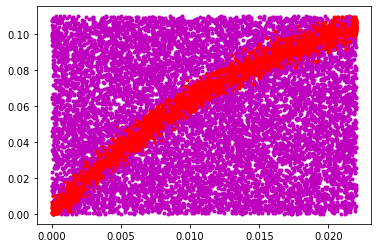

91000 0.8845463021366837
-17.899476232704426 0.20371757369255206
[ 4.07973321 11.01539572 10.99975788 10.97513901 10.94734325 10.92144599
 10.90093085 10.88732478 10.88085951 10.88055336 10.88076731 10.87561603
 10.86290927 10.84598298 10.84598533]


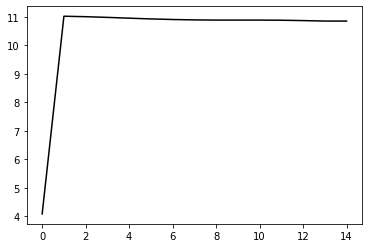

92000 0.9093487701612818
-18.576595719484455 0.23119146827579792
[ 4.02290245 11.18083336 11.16847274 11.14484351 11.11323776 11.07818528
 11.04497059 11.01834723 11.00114847 10.99309719 10.98977738 10.98406939
 10.97147069 10.9543819  10.92100676]


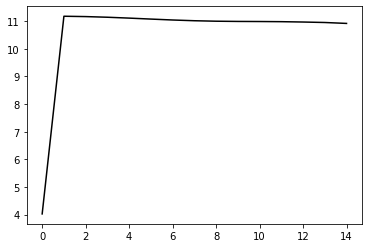

93000 0.9999997037053263
-18.843227423082336 0.03610139795966493
[ 4.00006157 10.7192514  10.71936331 10.72145644 10.72227716 10.72242926
 10.72375855 10.70309319 10.70578858 10.67593113 10.65897278 10.63593325
 10.61422494 10.5968711  10.5967598 ]


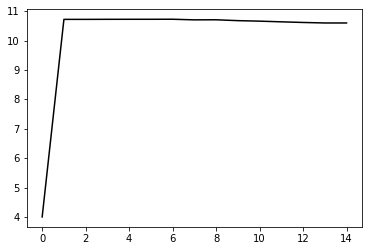

94000 0.8634689178084504
-19.131910041729167 0.21455906300074398
[ 4.07034391 10.82830012 10.81820835 10.80893089 10.80297525 10.80072624
 10.80277951 10.80941695 10.82084896 10.83391103 10.8407196  10.83634083
 10.81672282 10.79074382 10.80896072]


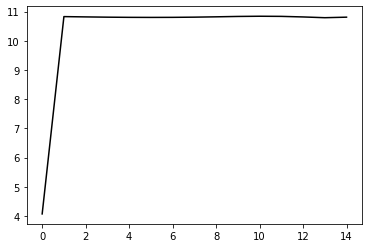

95000 1.0000190599235872
-19.561097462387764 0.024036835670755548
[ 3.92355033 10.9016786  10.8931987  10.87710323 10.85757225 10.83944876
 10.82650505 10.82096148 10.8230704  10.83032127 10.83640138 10.83334013
 10.81544579 10.78970365 10.7896963 ]


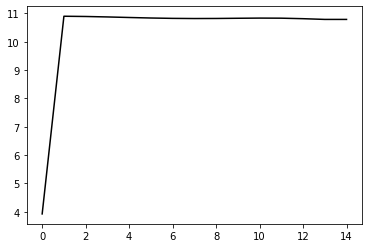

96000 0.999999713096743
-19.561096136071967 0.03086652069211422
[ 3.99978724 10.85295976 10.85522567 10.85492933 10.85306863 10.85771657
 10.85253846 10.85422437 10.85165676 10.84960039 10.84647566 10.84080503
 10.83238808 10.82091489 10.83204012]


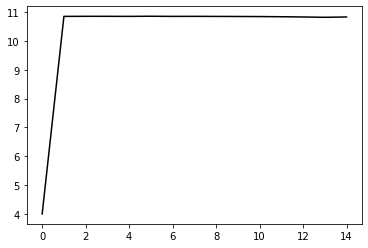

97000 1.0001698441278688
-19.86448302461586 -0.02927821318126578
[ 4.00001103 10.49952763 10.67786047 10.48453719 10.62037426 10.56629985
 10.58300963 10.58652402 10.59499717 10.60692483 10.62259065 10.63933256
 10.64963484 10.64845988 10.64862005]


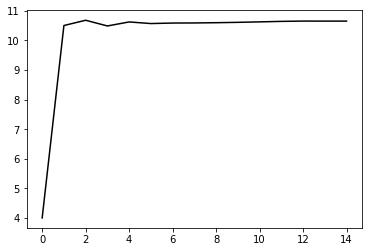

98000 1.0000003773779351
-20.007187382917373 0.009409786402656065
[ 4.00000008 10.04719065 10.04627485 10.0438823  10.03949116 10.03251947
 10.02260143 10.01012919  9.9972908   9.98864315  9.99128462 10.01316419
 10.04361169 10.05961187 10.05968357]


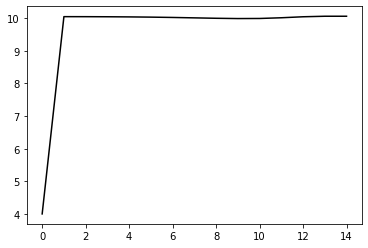

99000 1.0000106556484176
-20.00718738210705 0.010818167087771863
[ 4.00697339 10.02748607 10.02561284 10.03019474 10.01893886 10.0426621
 10.00207834 10.06119948  9.98536872 10.07626376  9.97465352 10.08305832
  9.97192788 10.07192479  9.97837248]


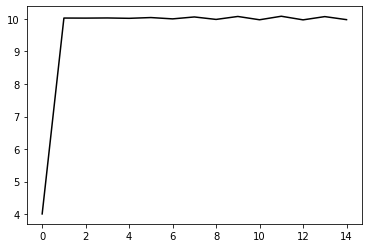

In [29]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, lamb, adsradius, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, lamb, adsradius])
        if np.isnan(loss)==True: break
    #for i in range (90):
        #optimizer.apply_gradients(zip(gradients, [h]))
        #if any(np.isnan(h.numpy()))==True: break
    for i in range (100):
        optimizer.apply_gradients(zip(gradients, [h, lamb, adsradius]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, lamb, adsradius, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(lamb.numpy(), adsradius.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, lamb, adsradius, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, lamb, adsradius, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

0 0.2683873594330554
2.8249807001754395 0.4244619325581797
[ 3.05184605e+00 -2.07612345e+00 -1.70295600e+00 -1.04227349e+00
 -1.86440309e-02  1.78133529e+00  4.95809104e+00  9.73921416e+00
  1.57557777e+01  2.24814509e+01  2.97269436e+01  3.74648813e+01
  4.54181467e+01  5.19679756e+01  5.19969410e+01]


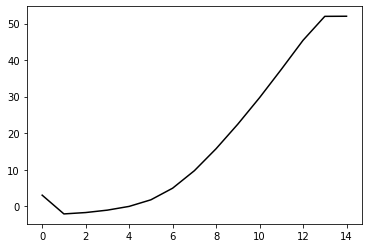

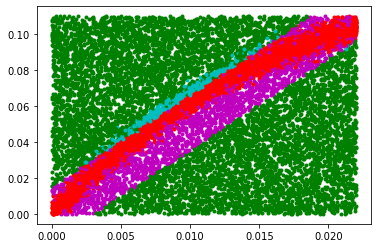

1000 0.32376991460881577
3.1040820228893518 0.4197204840669198
[ 3.07679852e+00 -2.07069770e+00 -1.69637581e+00 -1.03048103e+00
  3.94377735e-03  1.81790238e+00  5.00349310e+00  9.77826263e+00
  1.57738237e+01  2.24830673e+01  2.97106694e+01  3.74526407e+01
  4.54438648e+01  5.20665316e+01  5.20664887e+01]


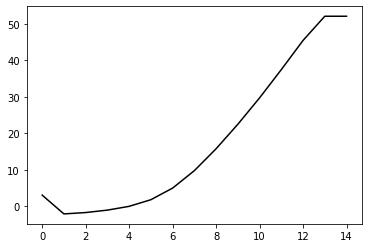

2000 0.32523979233903244
3.315488385890338 0.4161876928914999
[ 3.10576987e+00 -2.06270014e+00 -1.68650582e+00 -1.01373401e+00
  3.45874831e-02  1.86754702e+00  5.06943077e+00  9.84827789e+00
  1.58306387e+01  2.25020687e+01  2.97054236e+01  3.74772158e+01
  4.55113737e+01  5.22002371e+01  5.21692343e+01]


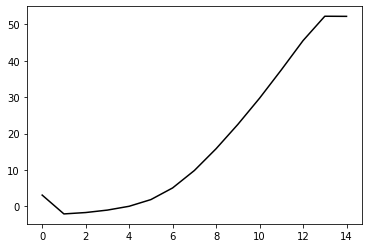

3000 0.24296242870220394
3.5076380135387146 0.41057447068881997
[ 3.12037566e+00 -2.06925519e+00 -1.69261842e+00 -1.01527185e+00
  4.31283294e-02  1.88822462e+00  5.09302542e+00  9.84949540e+00
  1.57736631e+01  2.23631937e+01  2.95027727e+01  3.72677803e+01
  4.53326625e+01  5.20873127e+01  5.20960000e+01]


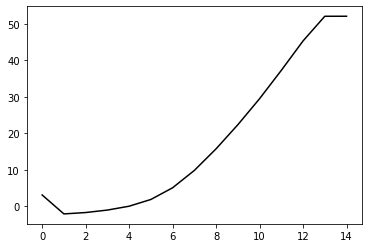

4000 0.29895880066593145
3.6776643991897564 0.40811708729769824
[ 3.12771414 -2.07872375 -1.69901895 -1.0135128   0.06047177  1.92779081
  5.15666743  9.93707761 15.89687476 22.54237172 29.72728334 37.52666135
 45.63086014 52.44566095 52.42545022]


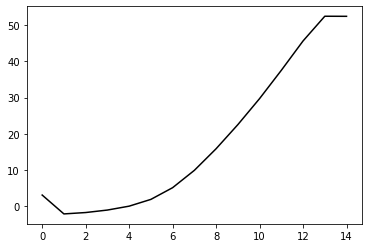

5000 0.3316873720302558
3.8537587842411716 0.4058147498685705
[ 3.1439765  -2.07918561 -1.69699615 -1.00425874  0.083745    1.97046208
  5.21764183 10.00832649 15.96779832 22.5915547  29.762933   37.58952038
 45.7354928  52.61116316 52.55962219]


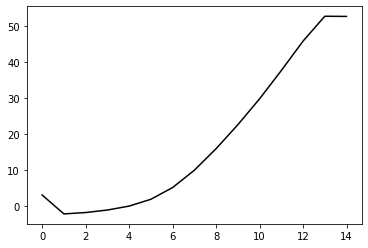

6000 0.23004762231978598
4.020521850127232 0.4021754291184403
[ 3.15237213 -2.09048434 -1.70706027 -1.00821544  0.09257434  1.99619685
  5.25494534 10.0396329  15.96846372 22.55088509 29.70490785 37.5406195
 45.722408   52.66200539 52.54400606]


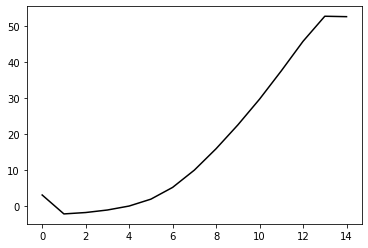

7000 0.25978383473482863
4.188460643072855 0.399902639657684
[ 3.12340692 -2.14015566 -1.75517662 -1.04936561  0.06597006  1.98940491
  5.26454772 10.0554245  15.9966261  22.63609091 29.84699679 37.71391041
 45.937578   52.94522008 52.89447152]


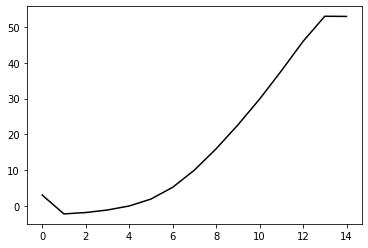

8000 0.2983596317495076
4.386693283344773 0.39689159836119337
[ 3.17814472 -2.10386183 -1.71803684 -1.00708646  0.119211    2.05635518
  5.33770293 10.11488436 16.01960138 22.61190969 29.78519535 37.6455047
 45.89727339 52.96477944 52.85306955]


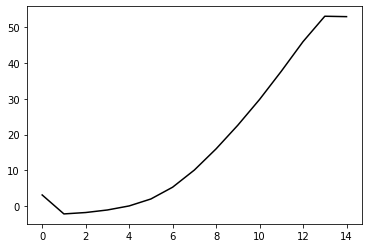

9000 0.24475080792726533
4.563311057419162 0.39482461526277474
[ 3.19661086 -2.10351419 -1.71641969 -0.99950153  0.13926876  2.0927444
  5.38500538 10.15801952 16.04549042 22.61930723 29.78519053 37.65574723
 45.94054894 53.06798195 52.98395314]


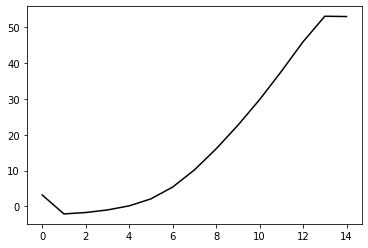

10000 0.2566086187008612
4.73857693248053 0.39289492094449713
[ 3.2074471  -2.1085768  -1.71935728 -0.99567139  0.1564207   2.12749983
  5.43323741 10.20692637 16.08133707 22.63627297 29.81235228 37.70715058
 46.02705474 53.20981098 53.11379083]


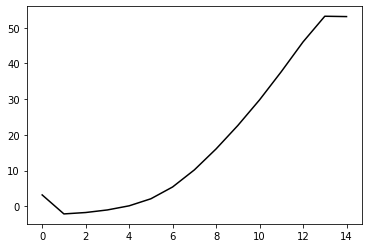

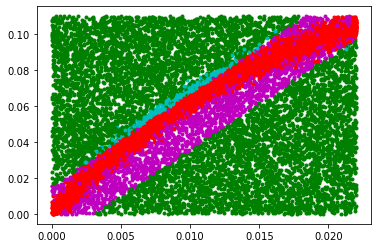

11000 0.22986601078291205
4.926813918193848 0.39068015755907753
[ 3.18688419 -2.14819388 -1.75769097 -1.02768726  0.13765961  2.12616666
  5.4439072  10.2152307  16.08018311 22.64121921 29.83021182 37.74372885
 46.10077561 53.34594755 53.31535601]


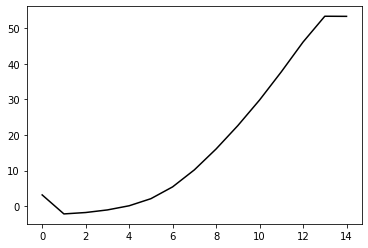

12000 0.254850912706408
5.1376449334807 0.39050226586550413
[ 3.21167312 -2.14079409 -1.7490505  -1.01334026  0.1638443   2.16725919
  5.49280442 10.25393036 16.09159096 22.62015694 29.79132956 37.71795202
 46.11331049 53.42313516 53.31584318]


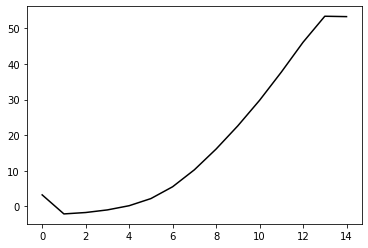

13000 0.3165107423881739
5.313498128562282 0.38215562946372345
[ 3.20205507 -2.16658572 -1.77336376 -1.03176922  0.15734498  2.17550334
  5.50816636 10.25768076 16.06435451 22.55608813 29.70797611 37.6372096
 46.06035694 53.42313712 53.42322355]


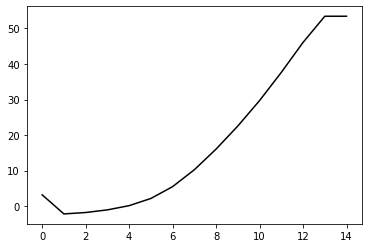

14000 0.2318563405045664
5.498897184611228 0.3852474771993716
[ 3.25647343 -2.12547544 -1.72982513 -0.98136687  0.22089504  2.25642004
  5.60299471 10.35555942 16.15256992 22.62105359 29.76710315 37.71297862
 46.16764868 53.58023975 53.54962206]


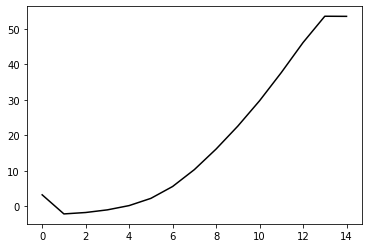

15000 0.2978399103739743
5.682314479351371 0.3852417508313631
[ 3.27910717 -2.1162649  -1.71812788 -0.96253272  0.25345874  2.30745745
  5.67022539 10.43148943 16.2332165  22.69973277 29.84331631 37.80544354
 46.29322155 53.75793982 53.70515785]


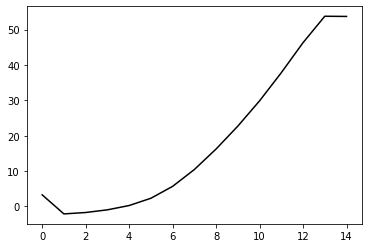

16000 0.3195893991330462
5.866977352889116 0.3839895533943873
[ 3.28207554 -2.12758432 -1.72753893 -0.96570545  0.26246425  2.33174846
  5.70390007 10.46187849 16.26059252 22.75417192 29.91650853 37.88815473
 46.40741596 53.92901252 53.92137206]


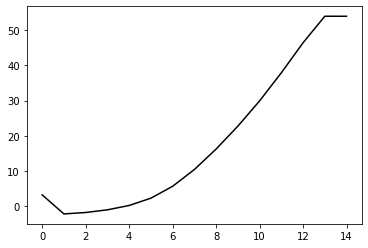

17000 0.350230829484966
6.054972178036364 0.3810080413105816
[ 3.2736262  -2.14870847 -1.7467709  -0.97905218  0.260469    2.34391923
  5.72448519 10.47704472 16.25665706 22.71975199 29.85791122 37.83190584
 46.38019878 53.95520074 53.851171  ]


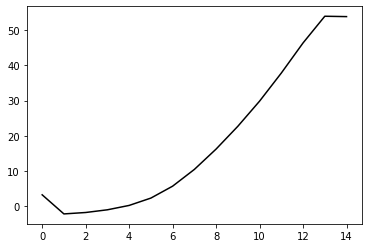

18000 0.20077420782088895
6.243015171913005 0.3771460758035155
[ 3.28874852 -2.1480653  -1.74512425 -0.97234097  0.27755058  2.37314983
  5.75728068 10.49537981 16.24825521 22.69834355 29.8382586  37.8186944
 46.3948634  54.0223703  53.9010992 ]


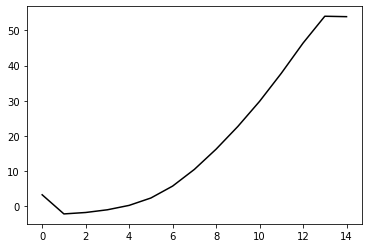

19000 0.36904945531338595
6.425538639671456 0.37966022326639853
[ 3.32226376 -2.12889935 -1.72393914 -0.94435086  0.31887847  2.43144646
  5.82703608 10.56466333 16.31317473 22.76144497 29.88821481 37.86589538
 46.46807816 54.15005804 54.11280873]


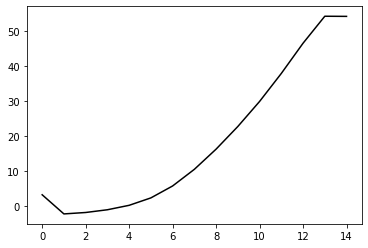

20000 0.3834625782020747
6.621823619660517 0.37755776239020034
[ 3.31475844 -2.14817022 -1.74039897 -0.9535102   0.32326135  2.45336646
  5.8631432  10.60751538 16.36177698 22.81058359 29.92727176 37.90889855
 46.53793845 54.27070903 54.23023583]


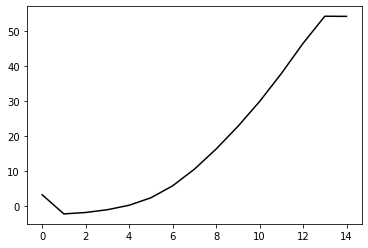

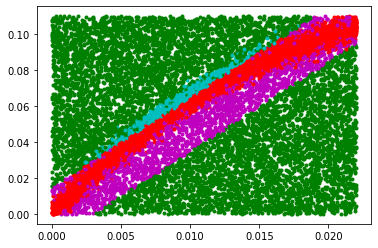

21000 0.2069203503512261
6.803858509318171 0.3712034773122845
[ 3.29112752 -2.18414505 -1.77486641 -0.98263733  0.30445546  2.44631955
  5.8591002  10.58769047 16.30503719 22.71362163 29.82299514 37.8103828
 46.4631979  54.24249899 54.22197642]


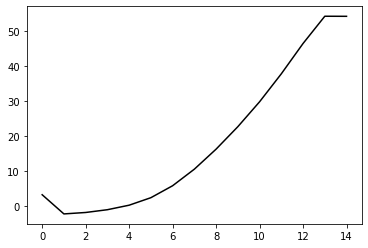

22000 0.24857802271008148
6.9816620114316175 0.37098434965243304
[ 3.3205838  -2.16650143 -1.7551111  -0.95629468  0.34345046  2.50161941
  5.92695024 10.6603923  16.38048176 22.78477599 29.88672332 37.87883255
 46.55417764 54.37705585 54.2877433 ]


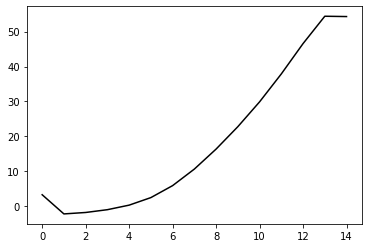

23000 0.3630034741117575
7.159036175816638 0.3708204537228679
[ 3.33329474 -2.16514441 -1.7512203  -0.94532942  0.36762207  2.54246094
  5.97958691 10.71236939 16.41060919 22.75539354 29.81642408 37.81355764
 46.5153129  54.38394438 54.38183666]


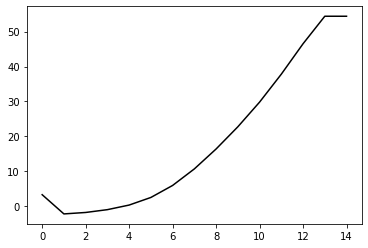

24000 0.2660653514070604
7.332184608555556 0.3683532262804204
[ 3.31203865 -2.19800996 -1.78145137 -0.96803699  0.35908873  2.55259151
  6.00622478 10.75188683 16.47233757 22.86404486 29.96005987 37.97098147
 46.69807922 54.61236078 54.53110559]


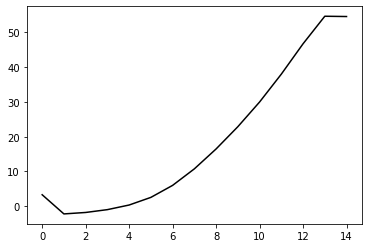

25000 0.3712710420069979
7.52870607833644 0.36994631345263057
[ 3.37350813 -2.15165791 -1.73486592 -0.91712881  0.41917797  2.62172367
  6.07112096 10.78569107 16.44837033 22.79483728 29.87290791 37.87975036
 46.62977835 54.59464553 54.54166255]


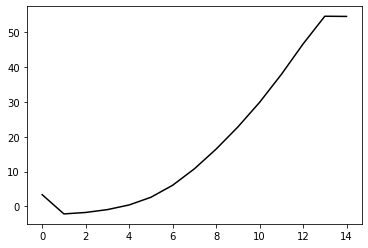

26000 0.28126256388497906
7.711660994833999 0.36742891300608055
[ 3.33770207 -2.19748051 -1.77829009 -0.95418056  0.3937664   2.61029269
  6.06791735 10.77962799 16.43069239 22.7527704  29.8196949  37.83573145
 46.6094359  54.61625022 54.62296773]


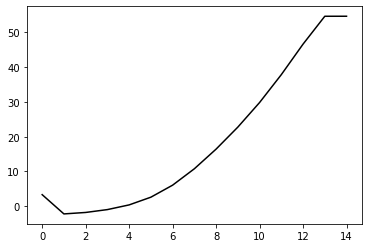

27000 0.3176421301150649
7.891596587311351 0.3646518385927528
[ 3.35625631 -2.19032433 -1.76983807 -0.94060638  0.41721177  2.64459308
  6.10436838 10.80186848 16.42540889 22.71958006 29.75969599 37.76294364
 46.54963512 54.59305453 54.57007636]


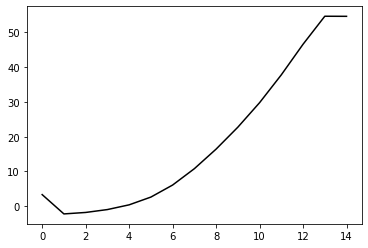

28000 0.26086349107139645
8.08337384654797 0.3638860596997267
[ 3.35676135 -2.20025868 -1.7776794  -0.94244406  0.42632964  2.66605853
  6.1301643  10.81555405 16.40549716 22.64555866 29.66202686 37.67323659
 46.48271512 54.56711657 54.56637522]


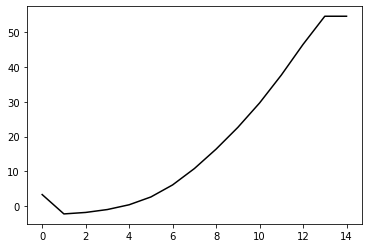

29000 0.24891019406284717
8.261212310735443 0.36320901530140076
[ 3.35358551 -2.21220371 -1.78636711 -0.94334885  0.43941499  2.69779772
  6.18096768 10.88979615 16.53111316 22.85983007 29.9312558  37.96543951
 46.80034056 54.92533626 54.80393457]


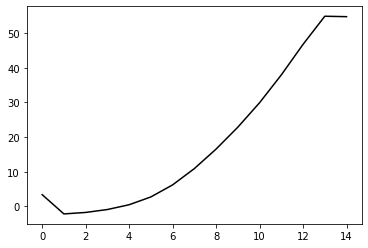

30000 0.21253169606601072
8.446803191909394 0.3615332655137243
[ 3.36175771 -2.21522403 -1.78831394 -0.94056388  0.45123924  2.71869711
  6.2003938  10.88758509 16.48562138 22.76636637 29.81396398 37.84630026
 46.69979772 54.86403777 54.84552635]


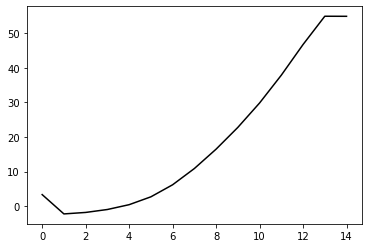

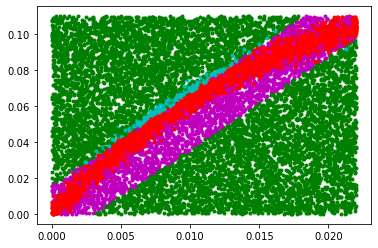

31000 0.3288086999353645
8.645661720949779 0.36201065254263326
[ 3.3760671  -2.21148274 -1.78291186 -0.929659    0.47230575  2.75064758
  6.23432517 10.90702202 16.4722706  22.70527341 29.72109778 37.74783245
 46.61858574 54.82168646 54.82566829]


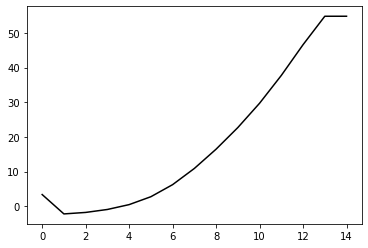

32000 0.3382423789774874
8.816285704713533 0.3613643719354377
[ 3.39476189 -2.20324422 -1.77291187 -0.91384034  0.49890925  2.78931906
  6.27744354 10.9412924  16.48959481 22.71194406 29.72368513 37.75495243
 46.64650985 54.89024455 54.88643034]


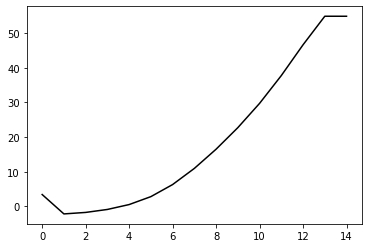

33000 0.2416405989623563
9.015836415368982 0.36153159628214776
[ 3.36808177 -2.23862149 -1.80488252 -0.93790048  0.48872393  2.79675151
  6.30107275 10.98287519 16.57225689 22.86958179 29.92783096 37.97088194
 46.88205229 55.16573692 55.16237539]


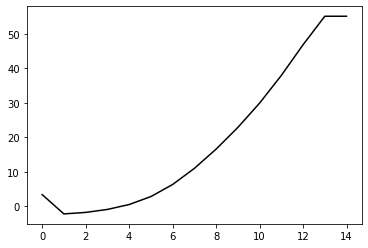

34000 0.2689639802191159
9.221505115524245 0.3593280939026754
[ 3.38130388 -2.23570345 -1.80092154 -0.92970887  0.50457969  2.81885197
  6.31663822 10.96696819 16.48801609 22.67799804 29.64631089 37.65433528
 46.57192375 54.89115432 54.91266944]


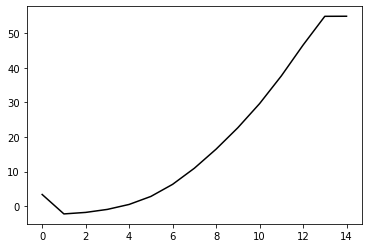

35000 0.22307142788511075
9.412081058687141 0.3592046181926546
[ 3.33942883 -2.28561999 -1.84752511 -0.96867433  0.47895039  2.81037503
  6.3249889  10.99617585 16.56345092 22.83588531 29.86129024 37.88532895
 46.82200689 55.17966085 55.16397198]


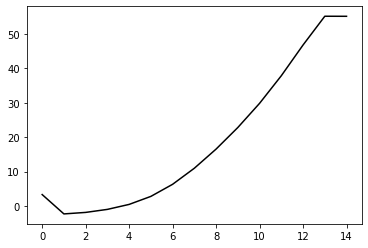

36000 0.29724862969591137
9.631687052864612 0.3596329126697478
[ 3.38051895 -2.25570477 -1.81635735 -0.9326649   0.52372058  2.86303093
  6.37386256 11.01992965 16.53389131 22.72438038 29.69667534 37.71257691
 46.66393443 55.05837899 55.04343235]


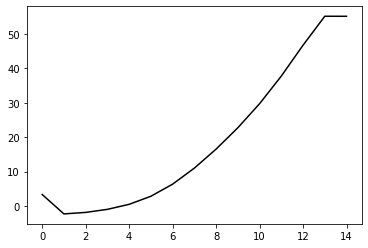

37000 0.33937868688809186
9.824758178389551 0.3596956478773968
[ 3.3818623  -2.26318361 -1.82151811 -0.93170279  0.53542634  2.88703779
  6.40518833 11.0523763  16.56825324 22.75795516 29.73046079 37.75402272
 46.72256362 55.15061093 55.14090353]


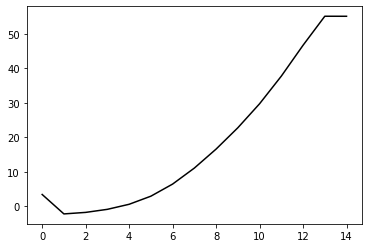

38000 0.2502003859795959
10.010793276112757 0.3575753053918139
[ 3.37818805 -2.27575977 -1.83239377 -0.93733298  0.53915335  2.90081085
  6.42261187 11.06475581 16.57272223 22.75659441 29.72519789 37.74705192
 46.72725223 55.18483054 55.09221787]


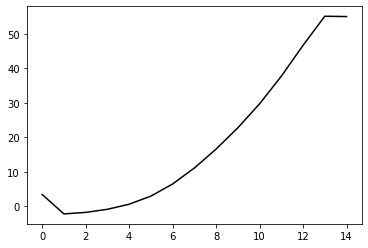

39000 0.2558164726179806
10.193702709154573 0.3575270222077461
[ 3.38189029 -2.2814863  -1.83610962 -0.93511849  0.55182318  2.92469906
  6.45052027 11.08484043 16.57107938 22.72252976 29.67854957 37.70463068
 46.70028234 55.18897786 55.07110228]


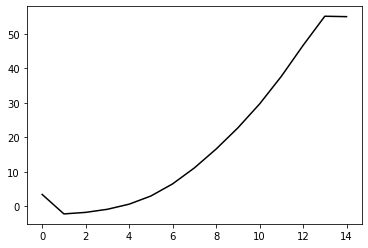

40000 0.25388642597812977
10.3744215950827 0.3547738398078289
[ 3.38701939 -2.28463289 -1.83730367 -0.9310132   0.56487062  2.94617803
  6.4711976  11.08845804 16.53684248 22.63947586 29.56612207 37.58387583
 46.58877991 55.10444123 55.05360493]


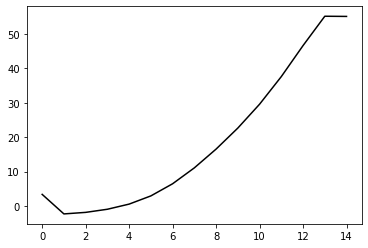

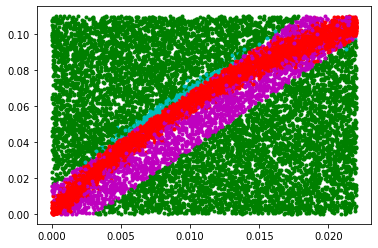

41000 0.233913959187988
10.576846799645882 0.3557205243774721
[ 3.38672086 -2.29510621 -1.84578829 -0.93338779  0.57325183  2.96603324
  6.49505836 11.10338599 16.52860705 22.6075936  29.53225821 37.56313758
 46.58935727 55.14078095 55.040829  ]


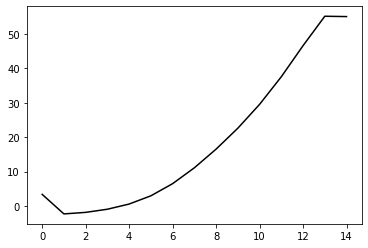

42000 0.2831119719699784
10.771571174746134 0.35700923578826527
[ 3.39418017 -2.29620198 -1.84422695 -0.92514944  0.59290985  2.99877363
  6.53653517 11.14839125 16.58084946 22.68373008 29.62623368 37.66549284
 46.70719606 55.28819063 55.18694539]


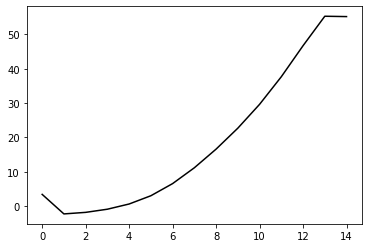

43000 0.23604594834358805
10.957669182781803 0.3563811575429395
[ 3.39750157 -2.30166846 -1.84746981 -0.92243267  0.60576777  3.02233573
  6.56427177 11.17064486 16.59315559 22.69249498 29.63096677 37.66811177
 46.72122143 55.33046815 55.22772853]


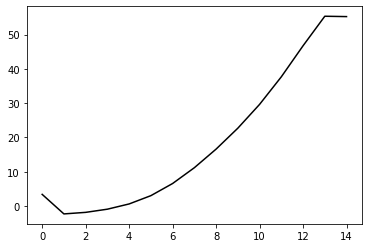

44000 0.3342611242267503
11.152396744416913 0.35651433246055303
[ 3.42032898 -2.28789635 -1.83194814 -0.90169712  0.63537592  3.06045076
  6.6028555  11.19831093 16.60599063 22.69366118 29.61312157 37.63854335
 46.69848053 55.33330155 55.31234999]


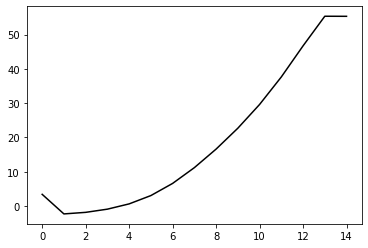

45000 0.5124474032158216
11.345708032877708 0.35838134192819443
[ 3.43168885 -2.2845301  -1.82474708 -0.8858609   0.66586642  3.10970684
  6.67204443 11.29426699 16.74696553 22.87563331 29.81204357 37.84758752
 46.92241186 55.58439103 55.54027331]


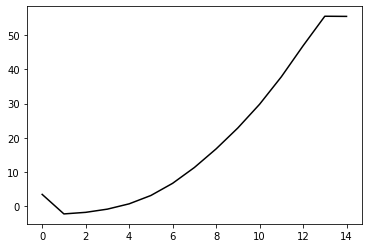

46000 0.209997102189855
11.521414651819981 0.3522019430920397
[ 3.37073735 -2.35184395 -1.88954591 -0.9449381   0.61602186  3.06943302
  6.6362141  11.25803335 16.71675909 22.87255365 29.83384264 37.87514718
 46.95966113 55.64470169 55.62972282]


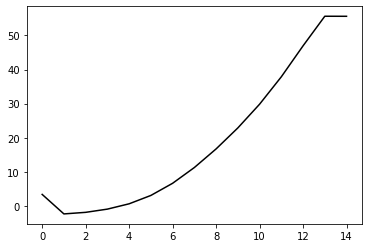

47000 0.2699648080331514
11.713831351043773 0.3493762689859264
[ 3.40981942 -2.32084885 -1.8574233  -0.9087907   0.65877914  3.11662747
  6.67647783 11.27111442 16.67199064 22.74340009 29.64571205 37.66358388
 46.75029254 55.45830873 55.36638697]


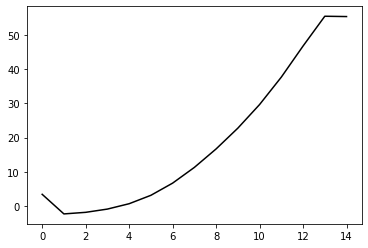

48000 0.2900828285129864
11.894803766360202 0.34879084274058403
[ 3.39810828 -2.33968643 -1.87385238 -0.91912945  0.65854073  3.12723887
  6.69318772 11.28938569 16.69723783 22.78756369 29.69948878 37.72245542
 46.82089232 55.55452594 55.55447102]


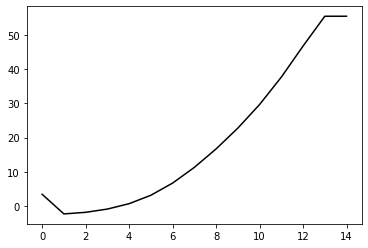

49000 0.3697123364553419
12.081747190648304 0.34929308511559704
[ 3.43154739 -2.31331772 -1.84535319 -0.88504737  0.70176435  3.17946125
  6.74741264 11.33353535 16.71358514 22.76620587 29.67093564 37.70221321
 46.81352863 55.57020601 55.48700386]


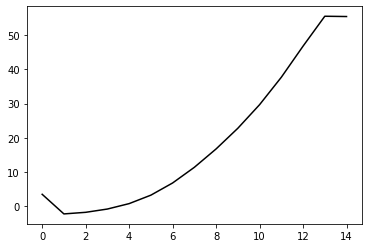

50000 0.32268837803393785
12.26482681357414 0.34900383319482636
[ 3.44289266 -2.30847715 -1.8380778  -0.87185697  0.72450078  3.21191854
  6.78407973 11.36819775 16.74607655 22.79625148 29.68397925 37.70159777
 46.81581448 55.59214426 55.56582427]


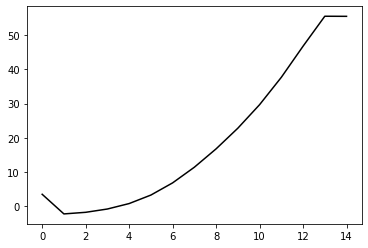

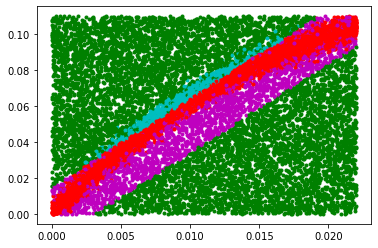

51000 0.24254180570893877
12.456936712435644 0.34698088777724084
[ 3.42414073 -2.33390351 -1.8611663  -0.88913384  0.71662807  3.21358391
  6.78978647 11.37207788 16.74998411 22.79837593 29.67236148 37.68675387
 46.8100591  55.6100004  55.61774958]


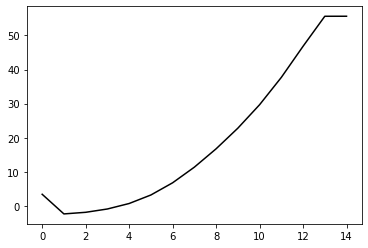

52000 0.2212697489737016
12.648007645692392 0.3457040563381021
[ 3.3819786  -2.3821842  -1.90678242 -0.92859569  0.6869571   3.19405931
  6.77559114 11.35835697 16.73859964 22.79859549 29.68372301 37.70251964
 46.83537297 55.65739599 55.6294766 ]


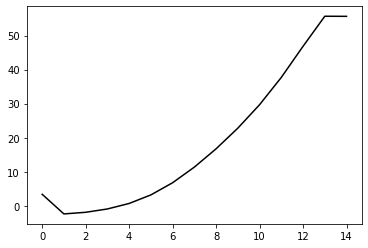

53000 0.25323703169583084
12.826601253770502 0.34461600905421824
[ 3.41493169 -2.35448129 -1.87595546 -0.89079102  0.73617311  3.25710165
  6.85225402 11.45170469 16.85427358 22.91870964 29.80230179 37.82908226
 46.97326047 55.81505788 55.71296662]


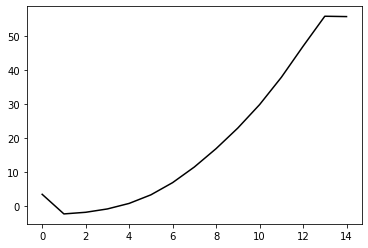

54000 0.2430335473132928
13.014472463888133 0.34472150928702505
[ 3.419163   -2.35692682 -1.87603516 -0.88487107  0.7517362   3.28239855
  6.88127136 11.47320008 16.84200454 22.84213802 29.7002648  37.73329254
 46.8907888  55.75412256 55.76301524]


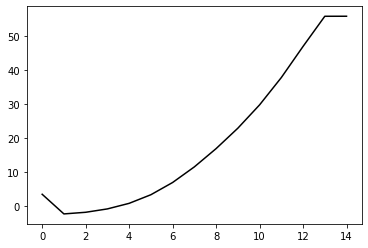

55000 0.23967129790519012
13.206306852966586 0.34247258041030504
[ 3.36997617 -2.41278814 -1.93016652 -0.93420023  0.70993857  3.2468604
  6.84416749 11.42296709 16.77150994 22.76792073 29.61349663 37.63312762
 46.79380087 55.6748309  55.61026473]


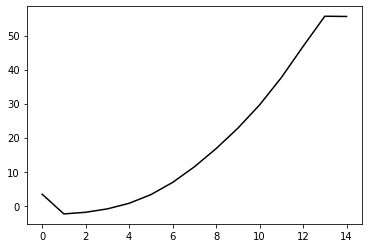

56000 0.27886961223232026
13.399315637183097 0.3425373082043578
[ 3.37380158 -2.415718   -1.93102809 -0.92961755  0.72315258  3.26819865
  6.86734048 11.43963431 16.77826508 22.76491512 29.58086694 37.57868319
 46.73917969 55.636756   55.58346286]


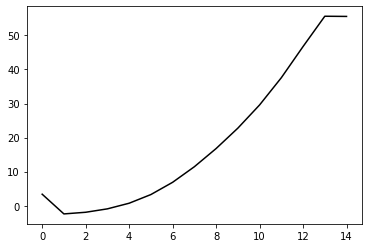

57000 0.2851665985852402
13.607506581345731 0.343098450396574
[ 3.39779622 -2.39976024 -1.91322146 -0.90641852  0.75501266  3.30800577
  6.90841244 11.47447276 16.80669862 22.78569092 29.59700109 37.59060264
 46.7558635  55.67108679 55.6481822 ]


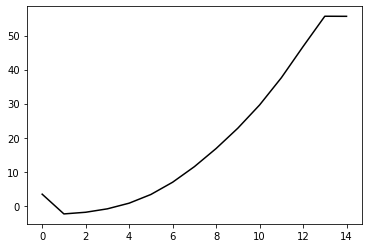

58000 0.34671941202310774
13.79663411021321 0.34776648692849754
[ 3.44771133 -2.3561263  -1.86592963 -0.85102656  0.82353372  3.39265951
  7.01044833 11.60142738 16.97920214 23.0159167  29.84213164 37.82590458
 46.99216801 55.92385506 55.85021393]


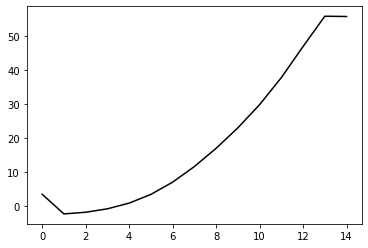

59000 0.2236037503845891
13.990948111993138 0.3428636321199126
[ 3.41779034 -2.39162813 -1.89946617 -0.87995232  0.80136735  3.37550948
  6.99039612 11.5659366  16.91001917 22.89587324 29.68289931 37.64711607
 46.81158776 55.75721371 55.76040598]


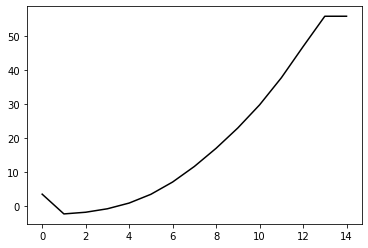

60000 0.22513152428377597
14.177129195488655 0.34130155986870536
[ 3.42623104 -2.38791433 -1.89319572 -0.86806033  0.82182166  3.40453556
  7.02414053 11.60110734 16.94621572 22.92570939 29.68996863 37.63185681
 46.79104209 55.74851205 55.7566137 ]


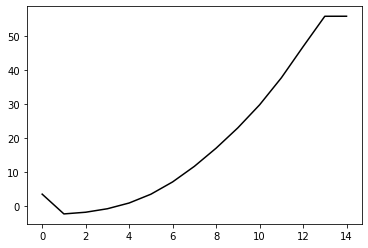

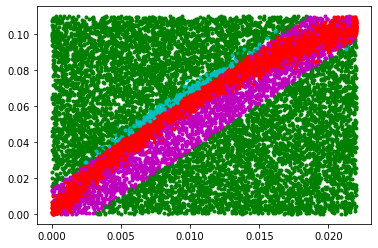

61000 0.2899609390820119
14.359364720177215 0.3378943620101147
[ 3.3907247  -2.4275661  -1.92983986 -0.89839284  0.8011582   3.39445329
  7.02274079 11.60864823 16.96705088 22.96158667 29.73371476 37.67152381
 46.83094722 55.80129192 55.76312363]


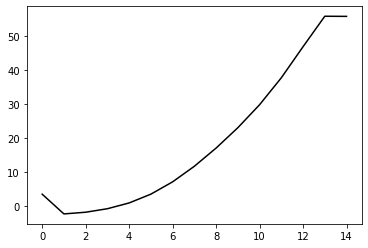

62000 0.21679974294088572
14.547219503762252 0.3375659582622328
[ 3.41696791 -2.40714596 -1.90776141 -0.87177698  0.83462934  3.43336346
  7.06030209 11.63608158 16.98032035 22.9741676  29.74629458 37.67160275
 46.82668512 55.8085866  55.8079233 ]


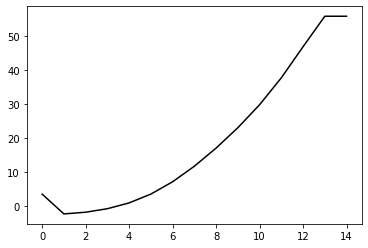

63000 0.3352801172447795
14.740119056616578 0.33787775815120075
[ 3.44211113 -2.38672611 -1.88484491 -0.84315306  0.87193642  3.47928785
  7.11080627 11.68655284 17.02336754 22.98620612 29.73329797 37.65266255
 46.80831239 55.8019889  55.79158869]


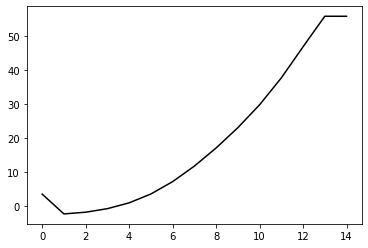

64000 0.30250832881213285
14.924148790371508 0.3364216537464636
[ 3.43360412 -2.40089777 -1.89670508 -0.84927604  0.87470885  3.4910668
  7.12779783 11.70473063 17.04253612 23.02233652 29.79211172 37.7173937
 46.87594586 55.88198511 55.77858903]


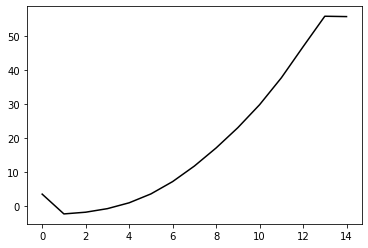

65000 0.32412101294152695
15.108808176001169 0.33675868161320427
[ 3.44223672 -2.39797853 -1.8917804  -0.83917649  0.89258943  3.51550949
  7.15176384 11.7150929  17.01073746 22.91485409 29.65315118 37.57847743
 46.74068756 55.75931625 55.7479306 ]


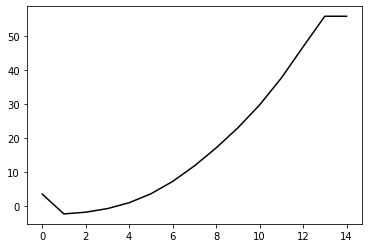

66000 0.27731528122518545
15.296230488590815 0.3362619897830232
[ 3.42591836 -2.41827804 -1.90874013 -0.84912259  0.89354924  3.52948756
  7.17964505 11.76199301 17.08847332 23.02840328 29.80121879 37.75176457
 46.92622952 55.959378   55.84546872]


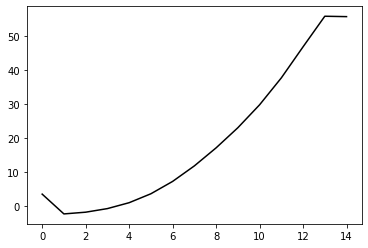

67000 0.24998288466323001
15.477790201287942 0.3361032658694895
[ 3.4376166  -2.41310149 -1.90235834 -0.83876906  0.90973741  3.54917764
  7.19468736 11.76161297 17.07077793 23.02332828 29.8089078  37.75845071
 46.93480927 55.97946951 55.8615251 ]


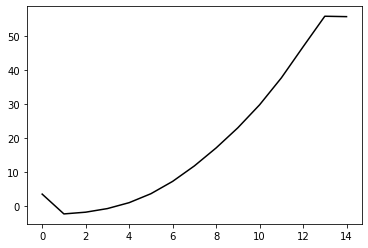

68000 0.16229864300883903
15.679432473098265 0.3349281357327912
[ 3.41108729 -2.44665118 -1.93478297 -0.86728608  0.88684589  3.52889981
  7.16683495 11.70922571 16.97164621 22.86977331 29.63908292 37.59351408
 46.77630117 55.83359446 55.81772929]


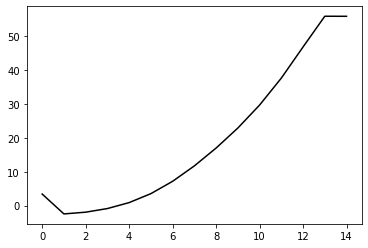

69000 0.23722028364475123
15.853626536273143 0.3355185112700854
[ 3.43633013 -2.42496918 -1.90931592 -0.83416939  0.93176297  3.58808464
  7.24135919 11.80114158 17.07416863 22.94877943 29.69013243 37.64177382
 46.82937116 55.89746692 55.90272174]


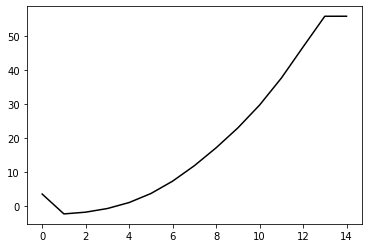

70000 0.26981421077454754
16.055693542506344 0.3334123309422585
[ 3.40649475 -2.46065584 -1.94359911 -0.86441679  0.90729422  3.56719579
  7.21636205 11.76132941 17.01790344 22.90469639 29.65098806 37.59704529
 46.78609197 55.86488831 55.84325274]


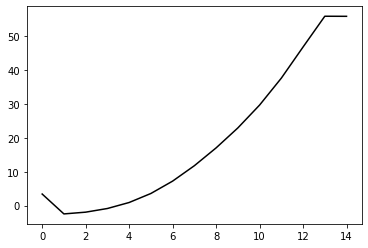

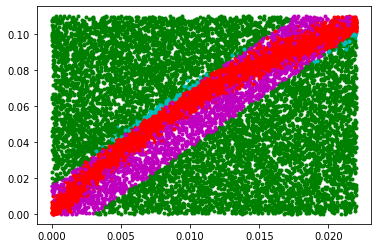

71000 0.22046174774922342
16.242587319265006 0.3341553070675632
[ 3.39246442 -2.47911647 -1.95893931 -0.87313609  0.90858489  3.57960282
  7.23916439 11.79791235 17.08377481 23.00838238 29.75723886 37.69371367
 46.88151088 55.96889476 55.91655355]


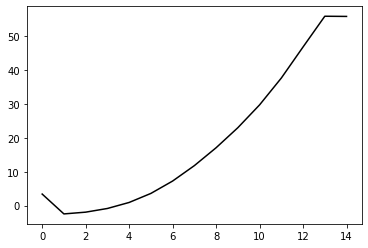

72000 0.3222017915340706
16.43700210164774 0.33331284491339597
[ 3.46555008 -2.41194819 -1.89118796 -0.80285816  0.98198986  3.65205819
  7.29946401 11.82791555 17.06308984 22.93398101 29.64170893 37.55107365
 46.73048452 55.82413749 55.8036373 ]


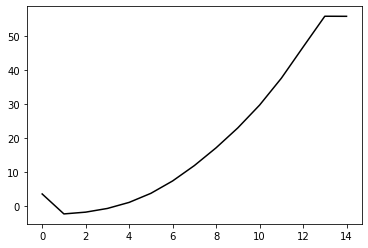

73000 0.3202357850637013
16.62093619114943 0.3313542925229534
[ 3.41026645 -2.4699603  -1.94582272 -0.85098836  0.9433883   3.62395117
  7.28111804 11.82114959 17.07203142 22.95365708 29.67540938 37.59408964
 46.77862838 55.88142966 55.84218415]


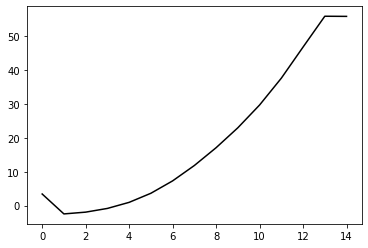

74000 0.195113721804662
16.806988450457382 0.331887543383902
[ 3.41716336 -2.46702468 -1.94047972 -0.84039037  0.96162115  3.64956169
  7.31143515 11.85665631 17.12394282 23.02764465 29.74951627 37.66256315
 46.84637436 55.95683419 55.87612818]


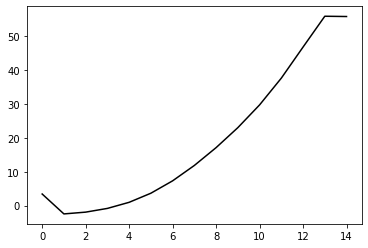

75000 0.24417979614576657
16.992983958452218 0.3307550201945801
[ 3.39893298 -2.48929538 -1.96087552 -0.85651113  0.95143298  3.64379937
  7.30461824 11.8414683  17.08849778 22.94591011 29.64123152 37.54933118
 46.73392942 55.85178546 55.82169922]


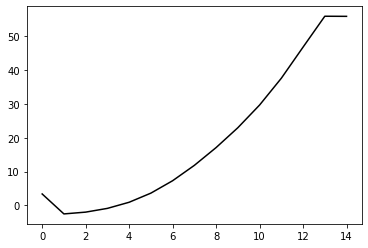

76000 0.32007444039724725
17.16853958893203 0.3323041199251867
[ 3.44817217 -2.44410285 -1.9134149  -0.80397435  1.01138558  3.71101834
  7.3767274  11.91855691 17.17561636 23.03667009 29.7214336  37.62192973
 46.80529295 55.92985067 55.91099036]


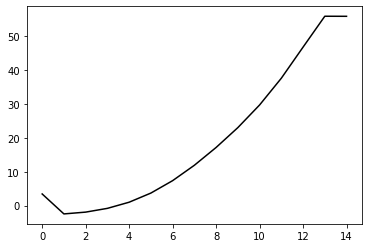

77000 0.30296827462606035
17.34479727844596 0.33041892765689385
[ 3.39155895 -2.50516953 -1.97208245 -0.85729256  0.96581235  3.67285966
  7.34268887 11.88470589 17.13666892 22.99849299 29.6901351  37.59313429
 46.7795612  55.9126236  55.84201559]


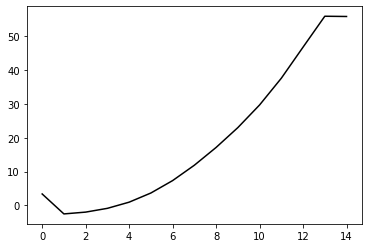

78000 0.31826597097713727
17.531458093953805 0.3305600361996334
[ 3.43301445 -2.46853782 -1.93348878 -0.8139094   1.01597005  3.72836651
  7.39762664 11.92865303 17.14950768 22.9661756  29.63778997 37.53564111
 46.72287145 55.86407095 55.75341597]


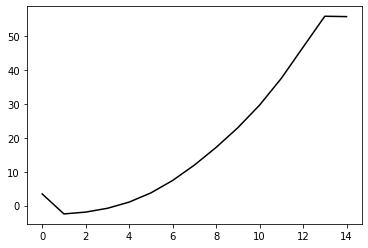

79000 0.3199054580917135
17.712514020685344 0.33060800571215276
[ 3.44062809 -2.46409743 -1.92631974 -0.80120343  1.03663682  3.75724468
  7.43302955 11.96956213 17.19404318 23.00658357 29.66935783 37.5632259
 46.75093573 55.89800903 55.89520129]


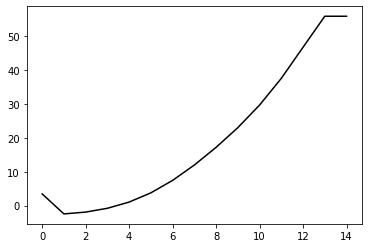

80000 0.3114094060239013
17.894351161910222 0.3298538226018534
[ 3.42501308 -2.48473888 -1.94499313 -0.81506012  1.02966484  3.756212
  7.43365536 11.96682619 17.18853392 23.01617012 29.68755143 37.57925021
 46.76726548 55.92107266 55.91614544]


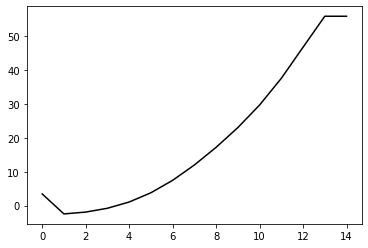

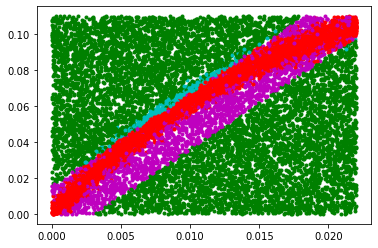

81000 0.3040814140579429
18.076485627698446 0.3251052259548211
[ 3.38619876 -2.52821333 -1.98657502 -0.85218233  0.99855761  3.72911076
  7.40400257 11.92472294 17.12504155 22.9399754  29.60801974 37.49516882
 46.68242285 55.84196366 55.81901617]


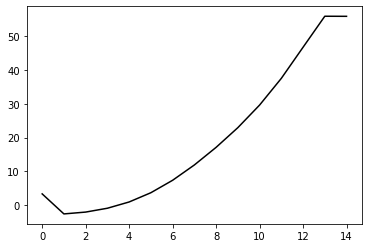

82000 0.24426101055834612
18.25541077134485 0.3282506601513758
[ 3.43219079 -2.48622239 -1.94225797 -0.80261889  1.05573999  3.79389612
  7.47426433 11.99973359 17.21086593 23.04681802 29.72319473 37.60657249
 46.79208621 55.95628948 55.83769631]


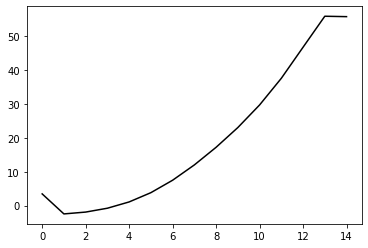

83000 0.3191068651061652
18.436642874224262 0.3262264119002296
[ 3.44510443 -2.47715018 -1.9314984  -0.78798576  1.07526358  3.81560191
  7.49047965 11.99874239 17.18252973 22.9979022  29.6636265  37.53851486
 46.7207982  55.88894473 55.86247559]


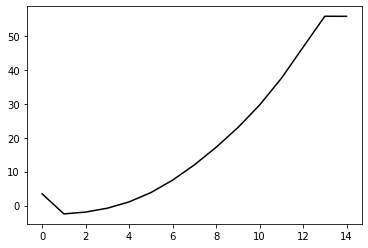

84000 0.24869480795610238
18.627021749519365 0.3283125838126768
[ 3.4346606  -2.49258568 -1.94502091 -0.79664558  1.07358168  3.81995847
  7.49628354 11.9985963  17.16358366 22.95408139 29.64732167 37.55176994
 46.74581293 55.92289875 55.79098785]


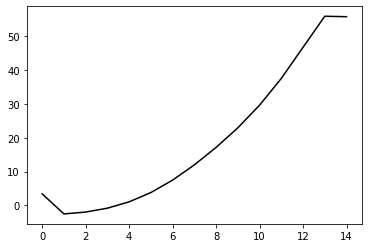

85000 0.27023390011342074
18.815635759486543 0.3293457391157817
[ 3.4083934  -2.52168812 -1.97065109 -0.81556979  1.06440636  3.82198263
  7.51054308 12.03022774 17.2221729  23.0296681  29.71761232 37.62234351
 46.8187014  56.00122849 55.91043509]


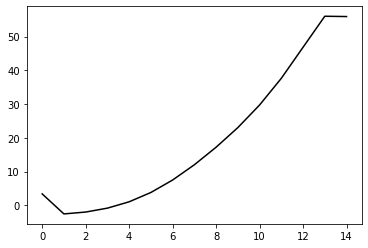

86000 0.29691886574779014
19.002034619279225 0.32977764650786445
[ 3.42519659 -2.50843007 -1.95521505 -0.79555282  1.09067564  3.85359479
  7.54382433 12.06060245 17.24340356 23.02154818 29.67687878 37.57197682
 46.76801509 55.95497471 55.95752356]


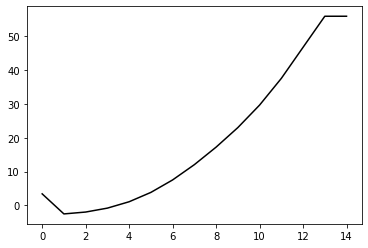

87000 0.2597958505071859
19.184448175452292 0.32758652832015495
[ 3.43770694 -2.50173497 -1.94793034 -0.78584825  1.102941    3.86387215
  7.54056568 12.02418628 17.15313119 22.8825697  29.50421848 37.38690957
 46.58187468 55.77358848 55.78620096]


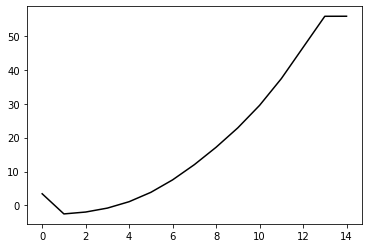

88000 0.17480897571847293
19.357692031625508 0.32726187110050436
[ 3.42508826 -2.5170511  -1.96008911 -0.79188166  1.10580387  3.87710027
  7.56582673 12.06921953 17.23749842 23.01616777 29.6533285  37.53462029
 46.73045459 55.92686394 55.92903161]


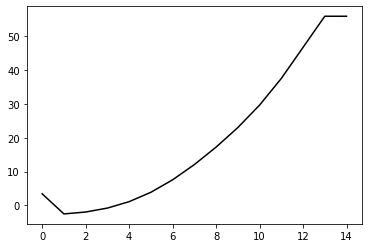

89000 0.23091844868139494
19.531743817358816 0.3249032847795705
[ 3.41397918 -2.53197401 -1.97324768 -0.80096858  1.10211761  3.87723717
  7.56522209 12.0637683  17.23111376 23.0227959  29.66080429 37.53171318
 46.72370503 55.92305505 55.91032411]


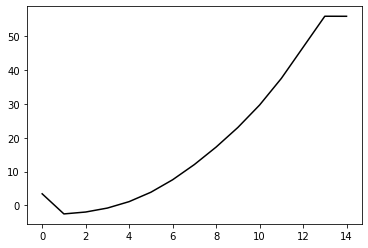

90000 0.3194607989078683
19.711619765802087 0.32513127450349144
[ 3.42891956 -2.52095138 -1.95990975 -0.78239006  1.12813764  3.91047247
  7.60357887 12.10726242 17.28460596 23.08559558 29.71913795 37.58014537
 46.76850357 55.97113628 55.85024976]


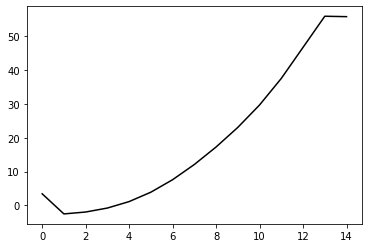

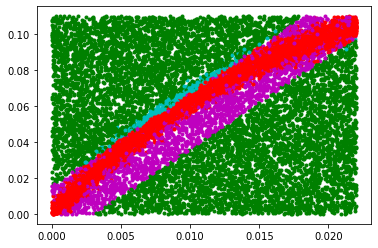

91000 0.2768719430913195
19.889332766267106 0.3235380645803254
[ 3.42350391 -2.53028134 -1.96751036 -0.78589085  1.13001736  3.91590221
  7.60757275 12.10523847 17.27931158 23.09149251 29.73479701 37.59280214
 46.77880908 55.98440804 55.97383823]


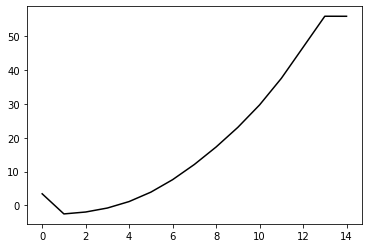

92000 0.22564385675932008
20.07629366921144 0.32323085185047207
[ 3.45136781 -2.50680028 -1.94308266 -0.75872834  1.16000698  3.94422846
  7.62281874 12.08581388 17.18627799 22.8970844  29.48390822 37.32088719
 46.49994607 55.70760678 55.71890651]


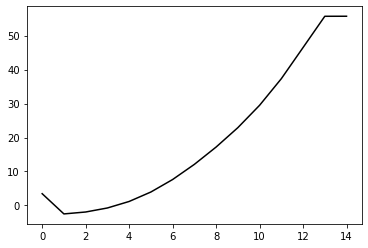

93000 0.252394155887047
20.2636935253357 0.3249840911264758
[ 3.42848671 -2.53296843 -1.96630448 -0.77590402  1.15171038  3.94644826
  7.63823499 12.12675412 17.28827119 23.08490264 29.71250627 37.55823746
 46.73875519 55.95017786 55.94740626]


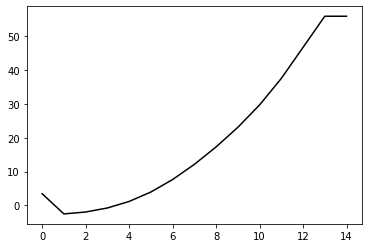

94000 0.20562390876175674
20.453235527699032 0.32329642170888023
[ 3.43419731 -2.53062499 -1.96215118 -0.76787263  1.16451026  3.96164823
  7.64960482 12.12513895 17.26074563 23.02914881 29.64769226 37.4881193
 46.66567798 55.87931941 55.81290128]


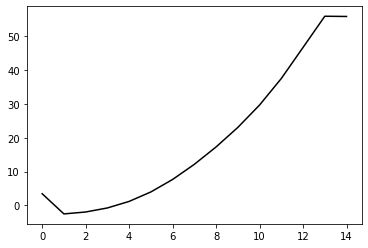

95000 0.2198693336416293
20.63152004664058 0.32474883973603924
[ 3.43815174 -2.52904159 -1.9572792  -0.75659874  1.18519679  3.9939621
  7.69733171 12.20022339 17.38190581 23.18613997 29.82732695 37.68050978
 46.86163746 56.07897846 55.99483655]


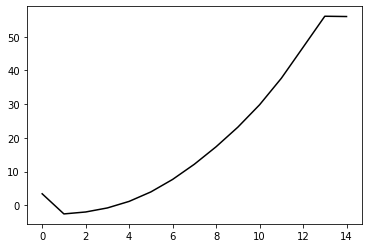

96000 0.34071054860365013
20.821757580521385 0.323514541180609
[ 3.45585607 -2.51579731 -1.94317981 -0.73984727  1.2048687   4.01302446
  7.70752789 12.18914385 17.33446342 23.1029256  29.72160904 37.56325414
 46.73995374 55.95890439 55.95941075]


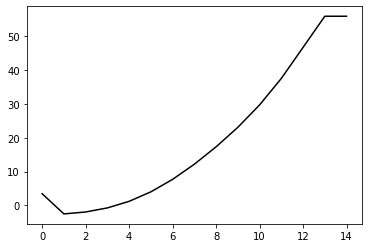

97000 0.2643423667003638
20.997502475696393 0.3200378486894427
[ 3.45344773 -2.52098989 -1.94674251 -0.74001915  1.20855622  4.0177312
  7.7064508  12.17189404 17.28559073 23.01371489 29.60305452 37.42891684
 46.59943377 55.81924675 55.8439994 ]


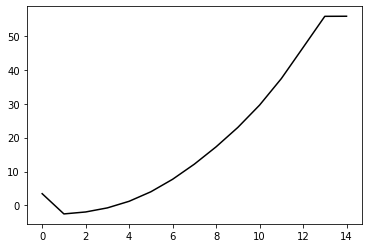

98000 0.3507018866114585
21.166474014875323 0.3195073088173594
[ 3.42149029 -2.55530366 -1.97822149 -0.76577968  1.19104911  4.00987709
  7.71064404 12.19805235 17.35824729 23.15616005 29.78790704 37.62506883
 46.79739967 56.01988921 56.00516163]


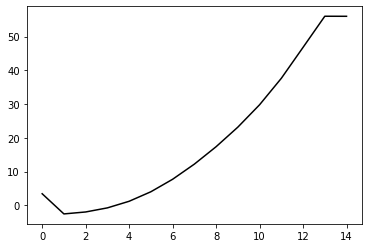

99000 0.18454682494199232
21.362170205884656 0.3214128586187221
[ 3.39505389 -2.58538522 -2.00592466 -0.78826421  1.17582957  4.00184041
  7.70887816 12.20581474 17.3888879  23.22336112 29.8739398  37.71210059
 46.88261232 56.10704871 56.08696475]


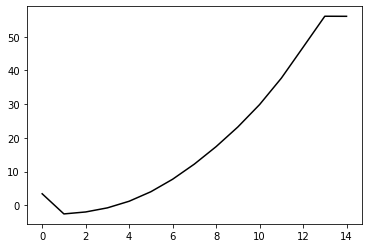

In [20]:
optimizer=tf.optimizers.Adam(learning_rate=0.0005)
for j in range (10000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, lamb, adsradius, Positive[j%set], Negative[j%set])
        gradients=g.gradient(loss, [h, lamb, adsradius])
        if np.isnan(loss)==True: break
    for i in range (90):
        optimizer.apply_gradients(zip(gradients, [h]))
        if any(np.isnan(h.numpy()))==True: break
    for i in range (10):
        optimizer.apply_gradients(zip(gradients, [h, lamb, adsradius]))
        if any(np.isnan(h.numpy()))==True: break
    if j%100==0: 
        print(j*10, Error_func(h, lamb, adsradius, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
        print(lamb.numpy(), adsradius.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()
    if j%1000==0:
        for i in range (set):
            [Positive0[i], Positive1[i]]=NN_func_01(h, lamb, adsradius, Positive[i])
            [Negative0[i], Negative1[i]]=NN_func_01(h, lamb, adsradius, Negative[i])
        for i in range (set):
            x_data1[i]=[v[0] for v in Positive0[i]]
            y_data1[i]=[v[1] for v in Positive0[i]]
            x_data2[i]=[v[0] for v in Positive1[i]]
            y_data2[i]=[v[1] for v in Positive1[i]]
            x_data3[i]=[v[0] for v in Negative0[i]]
            y_data3[i]=[v[1] for v in Negative0[i]]
            x_data4[i]=[v[0] for v in Negative1[i]]
            y_data4[i]=[v[1] for v in Negative1[i]]
            plt.plot(x_data4[i], y_data4[i], 'g.')
            plt.plot(x_data2[i], y_data2[i], 'c.')
            plt.plot(x_data1[i], y_data1[i], 'r.')
            plt.plot(x_data3[i], y_data3[i], 'm.')
        plt.show()

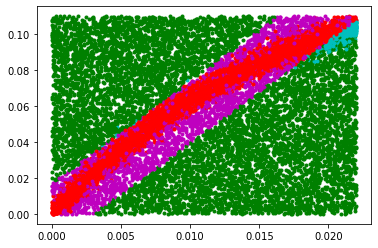

99990 0.19998561015996347
21.56395161708863 0.3198388914105071
[ 3.36837192 -2.61736919 -2.03810321 -0.81939455  1.14497906  3.96592618
  7.65655209 12.120305   17.253977   23.04696177 29.68551666 37.5190333
 46.68616484 55.91171918 55.85774422]


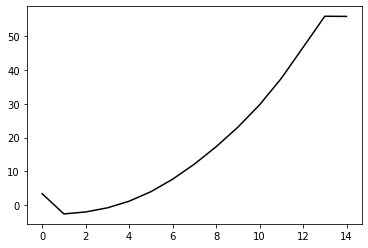

([<matplotlib.lines.Line2D at 0x1b45942f588>], None)

In [21]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, lamb, adsradius, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, lamb, adsradius, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()
print(j*10, Error_func(h, lamb, adsradius, Positive[np.int32((j/set)%set)], Negative[np.int32((j/set)%set)]).numpy())
print(lamb.numpy(), adsradius.numpy()), print(h.numpy())
plt.plot(h.numpy(), 'k-'), plt.show()